Here I used three regression-based ensemble ML models 1. Extreme Gradient Boosting (XGBoost), 2. Gradient-boosting Machine (GBM), and 3. Random Forest (RF) techniques, to predict medical insurance costs.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import chi2_contingency
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression, RFE, VarianceThreshold, SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
from yellowbrick.regressor import prediction_error, residuals_plot
from yellowbrick.model_selection import learning_curve
import shap
import time

import warnings
warnings.filterwarnings('ignore')

# Initialize SHAP JS visualization
shap.initjs()


In [5]:
# pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Set display options
df = pd.read_csv("Medicalpremium.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


In [6]:
# Looking at the top 5 records
df.head()

Age  Diabetes  BloodPressureProblems  AnyTransplants  AnyChronicDiseases  \
0   45         0                      0               0                   0   
1   60         1                      0               0                   0   
2   36         1                      1               0                   0   
3   52         1                      1               0                   1   
4   38         0                      0               0                   1   

   Height  Weight  KnownAllergies  HistoryOfCancerInFamily  \
0     155      57               0                        0   
1     180      73               0                        0   
2     158      59               0                        0   
3     183      93               0                        0   
4     166      88               0                        0   

   NumberOfMajorSurgeries  PremiumPrice  
0                       0         25000  
1                       0         29000  
2                       1         23000  
3                       2         28000  
4                       1         23000

In [7]:
# Looking at the Shape of the Dataset (rows, columns)
df.shape

(986, 11)

In [8]:
df.describe().T

count          mean          std      min      25%  \
Age                      986.0     41.745436    13.963371     18.0     30.0   
Diabetes                 986.0      0.419878     0.493789      0.0      0.0   
BloodPressureProblems    986.0      0.468560     0.499264      0.0      0.0   
AnyTransplants           986.0      0.055781     0.229615      0.0      0.0   
AnyChronicDiseases       986.0      0.180527     0.384821      0.0      0.0   
Height                   986.0    168.182556    10.098155    145.0    161.0   
Weight                   986.0     76.950304    14.265096     51.0     67.0   
KnownAllergies           986.0      0.215010     0.411038      0.0      0.0   
HistoryOfCancerInFamily  986.0      0.117647     0.322353      0.0      0.0   
NumberOfMajorSurgeries   986.0      0.667343     0.749205      0.0      0.0   
PremiumPrice             986.0  24336.713996  6248.184382  15000.0  21000.0   

                             50%      75%      max  
Age                         42.0     53.0     66.0  
Diabetes                     0.0      1.0      1.0  
BloodPressureProblems        0.0      1.0      1.0  
AnyTransplants               0.0      0.0      1.0  
AnyChronicDiseases           0.0      0.0      1.0  
Height                     168.0    176.0    188.0  
Weight                      75.0     87.0    132.0  
KnownAllergies               0.0      0.0      1.0  
HistoryOfCancerInFamily      0.0      0.0      1.0  
NumberOfMajorSurgeries       1.0      1.0      3.0  
PremiumPrice             23000.0  28000.0  40000.0

We can observe that:

There are no null values

The numerical features Age, Height and Weight have different scales, so I will be standardizing these 3 features.

Premium Price has a high standard deviation which means some individuals may have much higher or lower premiums than the mean premium, indicating a diverse range of pricing.

In [10]:
# Updating the datatype for object variable
for i in df[['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']]: 
     df[i]=df[i].astype('object')

In [11]:
# Looking at the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      986 non-null    int64 
 1   Diabetes                 986 non-null    object
 2   BloodPressureProblems    986 non-null    object
 3   AnyTransplants           986 non-null    object
 4   AnyChronicDiseases       986 non-null    object
 5   Height                   986 non-null    int64 
 6   Weight                   986 non-null    int64 
 7   KnownAllergies           986 non-null    object
 8   HistoryOfCancerInFamily  986 non-null    object
 9   NumberOfMajorSurgeries   986 non-null    object
 10  PremiumPrice             986 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 84.9+ KB


We can observe that there are 11 colummns and 986 records.

Data type for all the variables are integer but I converted Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, KnownAllergies, HistoryOfCancerInFamily, NumberOfMajorSurgeries to object type

In [13]:
# Checking for Null Values
df.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

In [14]:
df.shape

(986, 11)

In [15]:
cols = df.columns
cols

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

In [16]:
# Seprating the object and numeric variable
cat = []
num = []
for i in df.columns:
    if df[i].dtype=='object':
        cat.append(i)
    else:
        num.append(i)

In [17]:
num,cat

(['Age', 'Height', 'Weight', 'PremiumPrice'],
 ['Diabetes',
  'BloodPressureProblems',
  'AnyTransplants',
  'AnyChronicDiseases',
  'KnownAllergies',
  'HistoryOfCancerInFamily',
  'NumberOfMajorSurgeries'])

# EDA

In [18]:
df[num].describe().T

count          mean          std      min      25%      50%  \
Age           986.0     41.745436    13.963371     18.0     30.0     42.0   
Height        986.0    168.182556    10.098155    145.0    161.0    168.0   
Weight        986.0     76.950304    14.265096     51.0     67.0     75.0   
PremiumPrice  986.0  24336.713996  6248.184382  15000.0  21000.0  23000.0   

                  75%      max  
Age              53.0     66.0  
Height          176.0    188.0  
Weight           87.0    132.0  
PremiumPrice  28000.0  40000.0

Observations: 

Minimum Age of User is 18 years and Maximum Age is 66 years where Average Age is 42 years.

Minimum Height of the User 145 and Maximum Height is 188 and Average Height is 168. 

Minimum Weight of the User 51 and Maximum Weight is 132 and Average Weight is 77. 

Minimum Premium Price that User Pays is 15000 and Maximum Premium Price is 40000 while the Average Premium price is 24337.

We observe that the Standard deviation is very large for Premium Price.

In [19]:
cat_stat=df[cat].describe().T
cat_stat['no']= cat_stat['count']- cat_stat['freq']
cat_stat

count  unique  top  freq   no
Diabetes                   986       2    0   572  414
BloodPressureProblems      986       2    0   524  462
AnyTransplants             986       2    0   931   55
AnyChronicDiseases         986       2    0   808  178
KnownAllergies             986       2    0   774  212
HistoryOfCancerInFamily    986       2    0   870  116
NumberOfMajorSurgeries     986       4    0   479  507

Text(0.5, 1.0, ' Distribution of PremiumPrice')

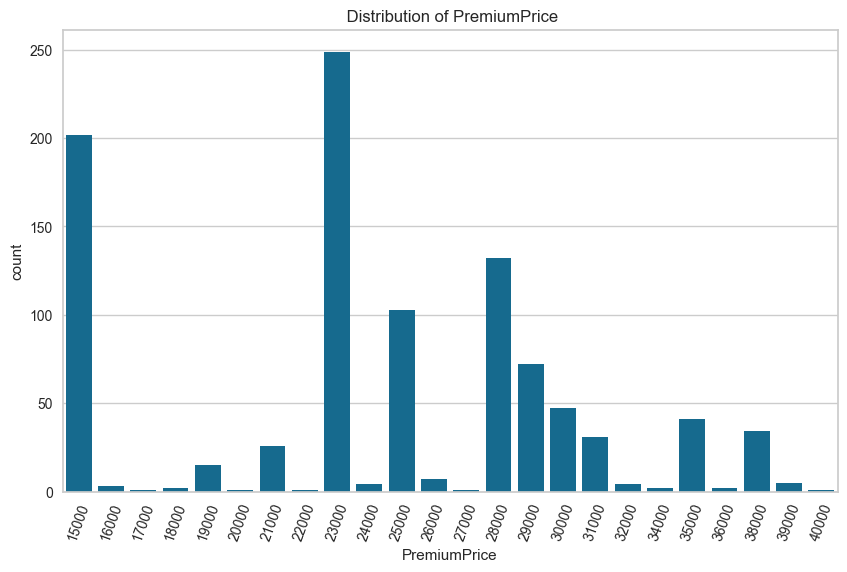

In [20]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=70) #  rotate the x-axis tick labels
sns.countplot(x='PremiumPrice', data=df).set_title(f' Distribution of PremiumPrice')

We can observe:

The distribution is skewed towards the right end of the premium price which suggest that the graph is a left skewed.

Most of the user's who pay PremiumPrice's are in the range >=23000 and <=31000.

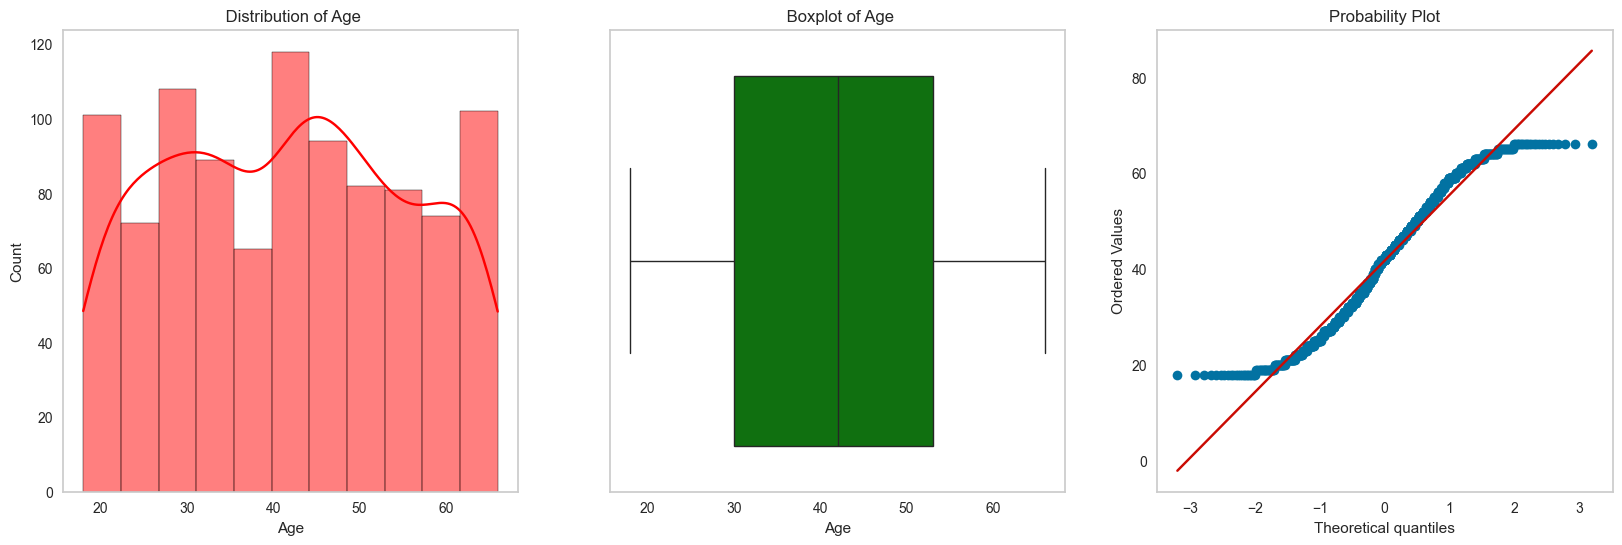

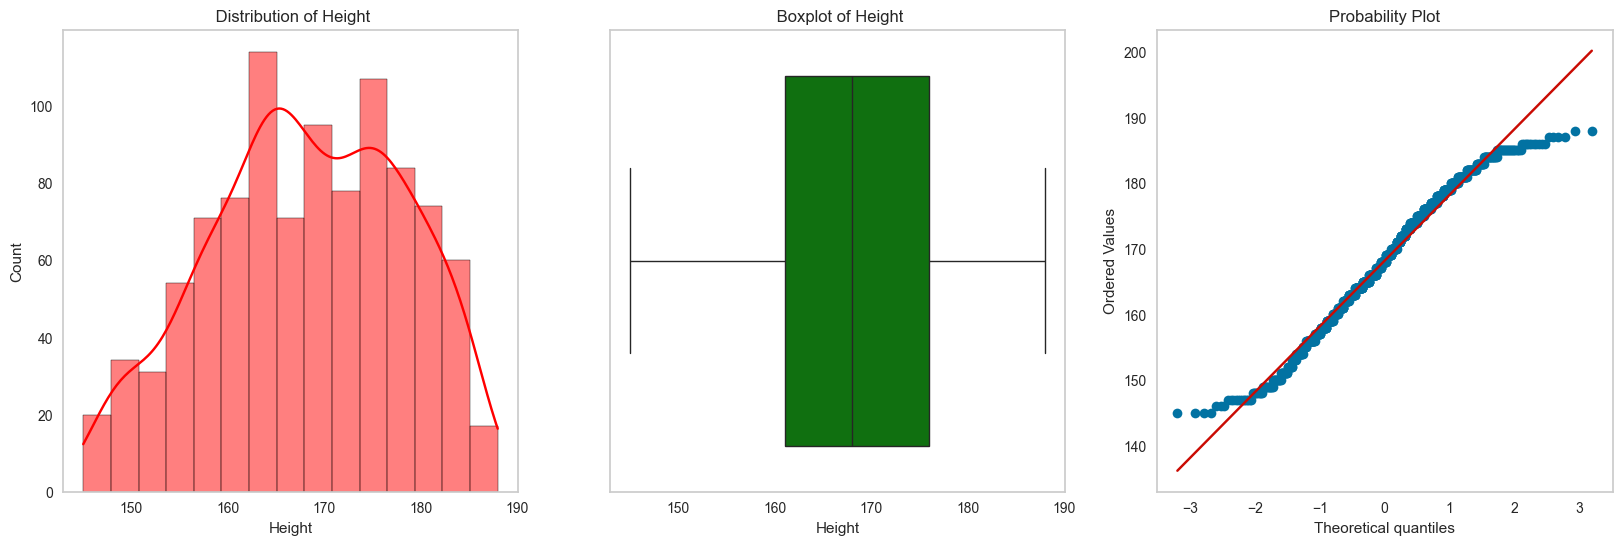

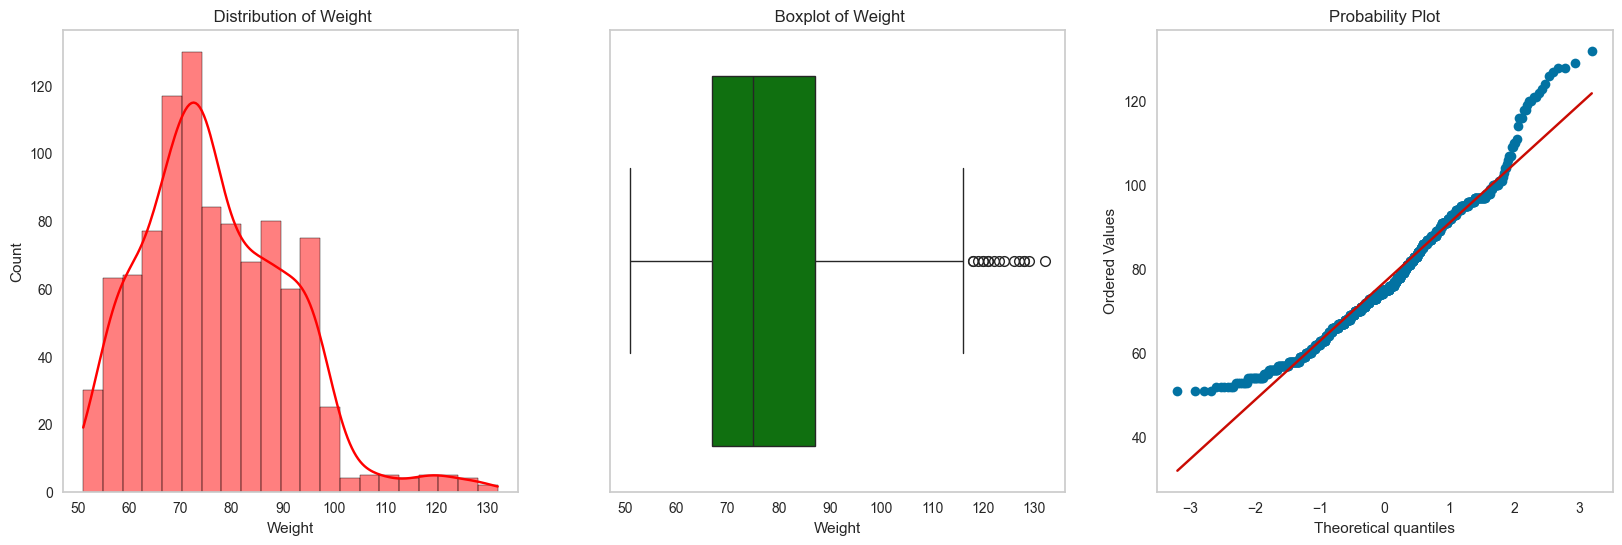

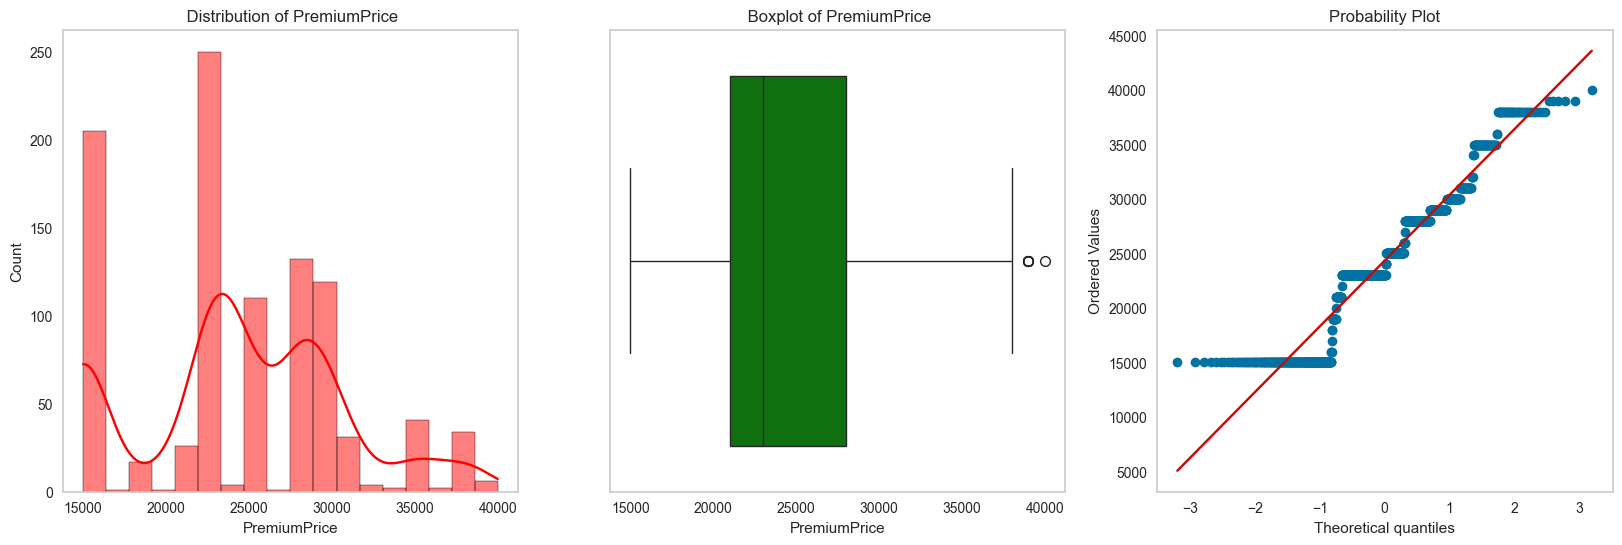

In [21]:
# Histogram with Box Plot and Probability plot
for i in df[num]:
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
    sns.histplot(df[i],kde=True,ax=ax[0], color='red').set_title(f' Distribution of {i}')
    sns.boxplot(df[i],ax=ax[1], color='green', orient='h').set_title(f' Boxplot of {i}')
    probplot(df[i],plot=ax[2])
    ax[0].grid(False)
    ax[1].grid(False)
    ax[2].grid(False)

We observe that there are outliers. Because of having less amount of data we can not drop samples.

The distribution of patient heights right skewed with centre of 168 with no outlier.

The distribution of patient weights left skewed with centre of 75 and it will be better if during the model building process we used tree based models and SVM, so that it can handle the skeweness well rather than doing transformations right now.

Here, most people height is >160 and weight is <100

In [22]:
df[df['Weight'] > 110]

Age Diabetes BloodPressureProblems AnyTransplants AnyChronicDiseases  \
151   47        0                     0              0                  0   
154   21        0                     0              0                  0   
158   43        0                     0              0                  0   
160   58        1                     1              0                  0   
175   55        0                     0              0                  0   
183   36        0                     0              0                  0   
186   19        0                     0              0                  0   
192   50        1                     0              0                  0   
195   19        0                     0              0                  0   
196   39        0                     1              0                  0   
203   24        0                     1              0                  0   
204   27        0                     1              0                  0   
206   31        1                     1              0                  0   
207   18        0                     0              0                  0   
213   46        0                     0              0                  0   
217   65        0                     1              0                  0   
218   62        0                     1              1                  0   
221   61        0                     1              0                  1   
225   57        1                     0              0                  0   
227   44        0                     0              0                  0   
228   22        1                     1              0                  0   

     Height  Weight KnownAllergies HistoryOfCancerInFamily  \
151     169     116              0                       0   
154     157     118              1                       0   
158     158     121              0                       0   
160     180     116              0                       0   
175     162     116              0                       0   
183     156     119              0                       0   
186     173     129              1                       0   
192     163     127              0                       0   
195     164     132              0                       0   
196     174     120              0                       0   
203     173     128              0                       0   
204     159     120              1                       1   
206     174     114              0                       0   
207     172     123              0                       1   
213     170     111              0                       1   
217     177     126              0                       0   
218     164     121              1                       0   
221     174     118              0                       0   
225     160     128              0                       0   
227     182     124              0                       1   
228     166     122              0                       0   

    NumberOfMajorSurgeries  PremiumPrice  
151                      1         35000  
154                      1         15000  
158                      0         23000  
160                      1         35000  
175                      1         35000  
183                      0         23000  
186                      0         15000  
192                      2         28000  
195                      0         15000  
196                      0         23000  
203                      1         26000  
204                      1         39000  
206                      1         23000  
207                      1         15000  
213                      1         22000  
217                      2         24000  
218                      1         38000  
221                      1         35000  
225                      0         35000  
227                      1         31000  
228                      0         15000

Here we can see that all these records which are outliers for weight, have very high values or weight. This might be due to data inconsitency. But it is possible for people to have different weights. Since, the number of outliers is very small compared to the number of records in the dataset, I will not remove these outliers as they contain different important information like 'NumberOfMajorSurgeries'. Also, I will have to make sure to use Ensemble Models so that they are robust to outliers.

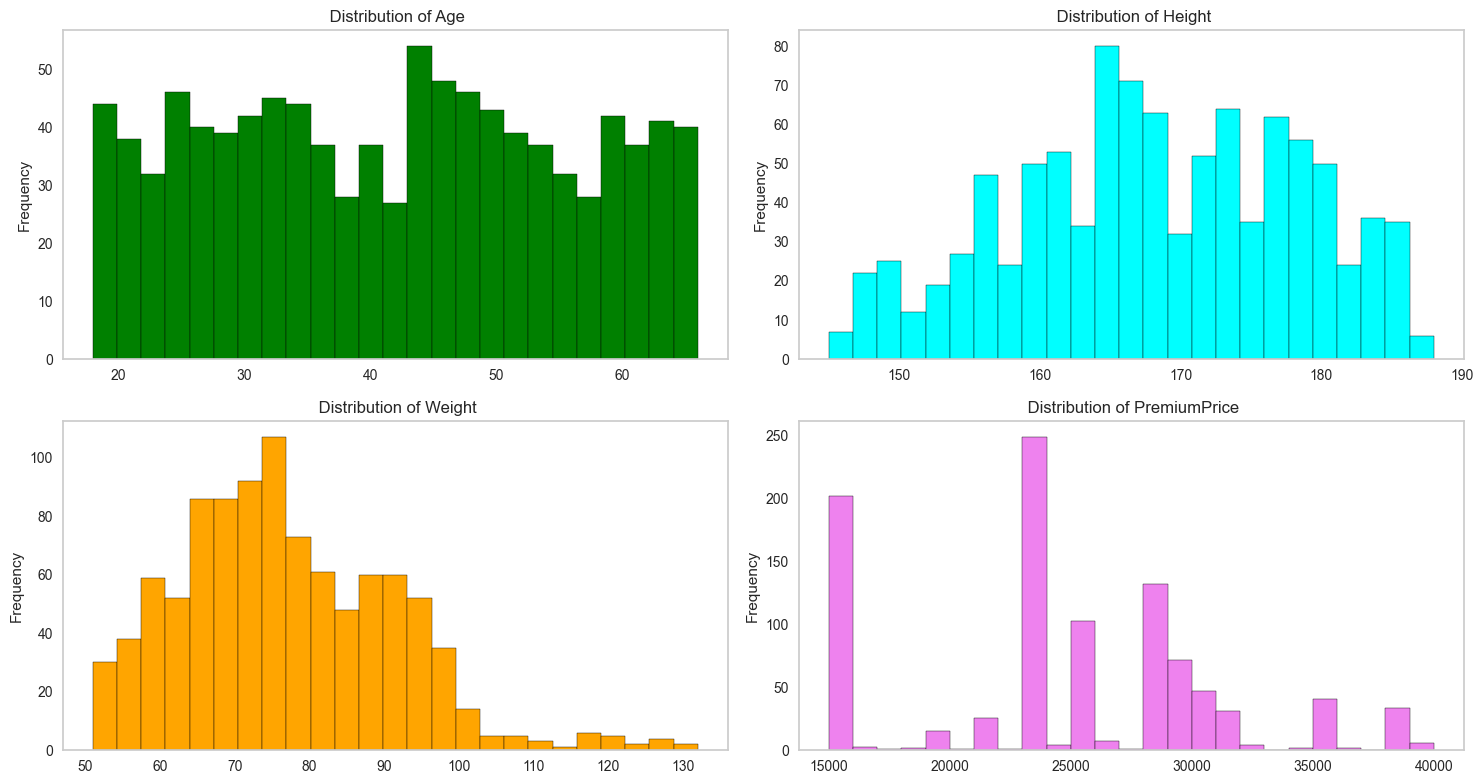

In [23]:
# Univariate Analysis
# variables = df[num]
colors = ['green', 'cyan', 'orange', 'violet']#, 'cyan']
titles = ['Age', 'Height', 'Weight', 'PremiumPrice']#, 'BMI']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

for i, var in enumerate(df[num]):
    row = i // 2 #3
    col = i % 2 #3
    df[var].plot.hist(bins=25, edgecolor='black', color=colors[i], ax=ax[row][col])
    ax[row][col].set_title(f' Distribution of {titles[i]}')
    ax[row][col].grid(False)

# # Remove unused subplots
# for i in range(len(titles), 2 * 3):
#     ax.flatten()[i].axis('off')
plt.tight_layout()
plt.show()

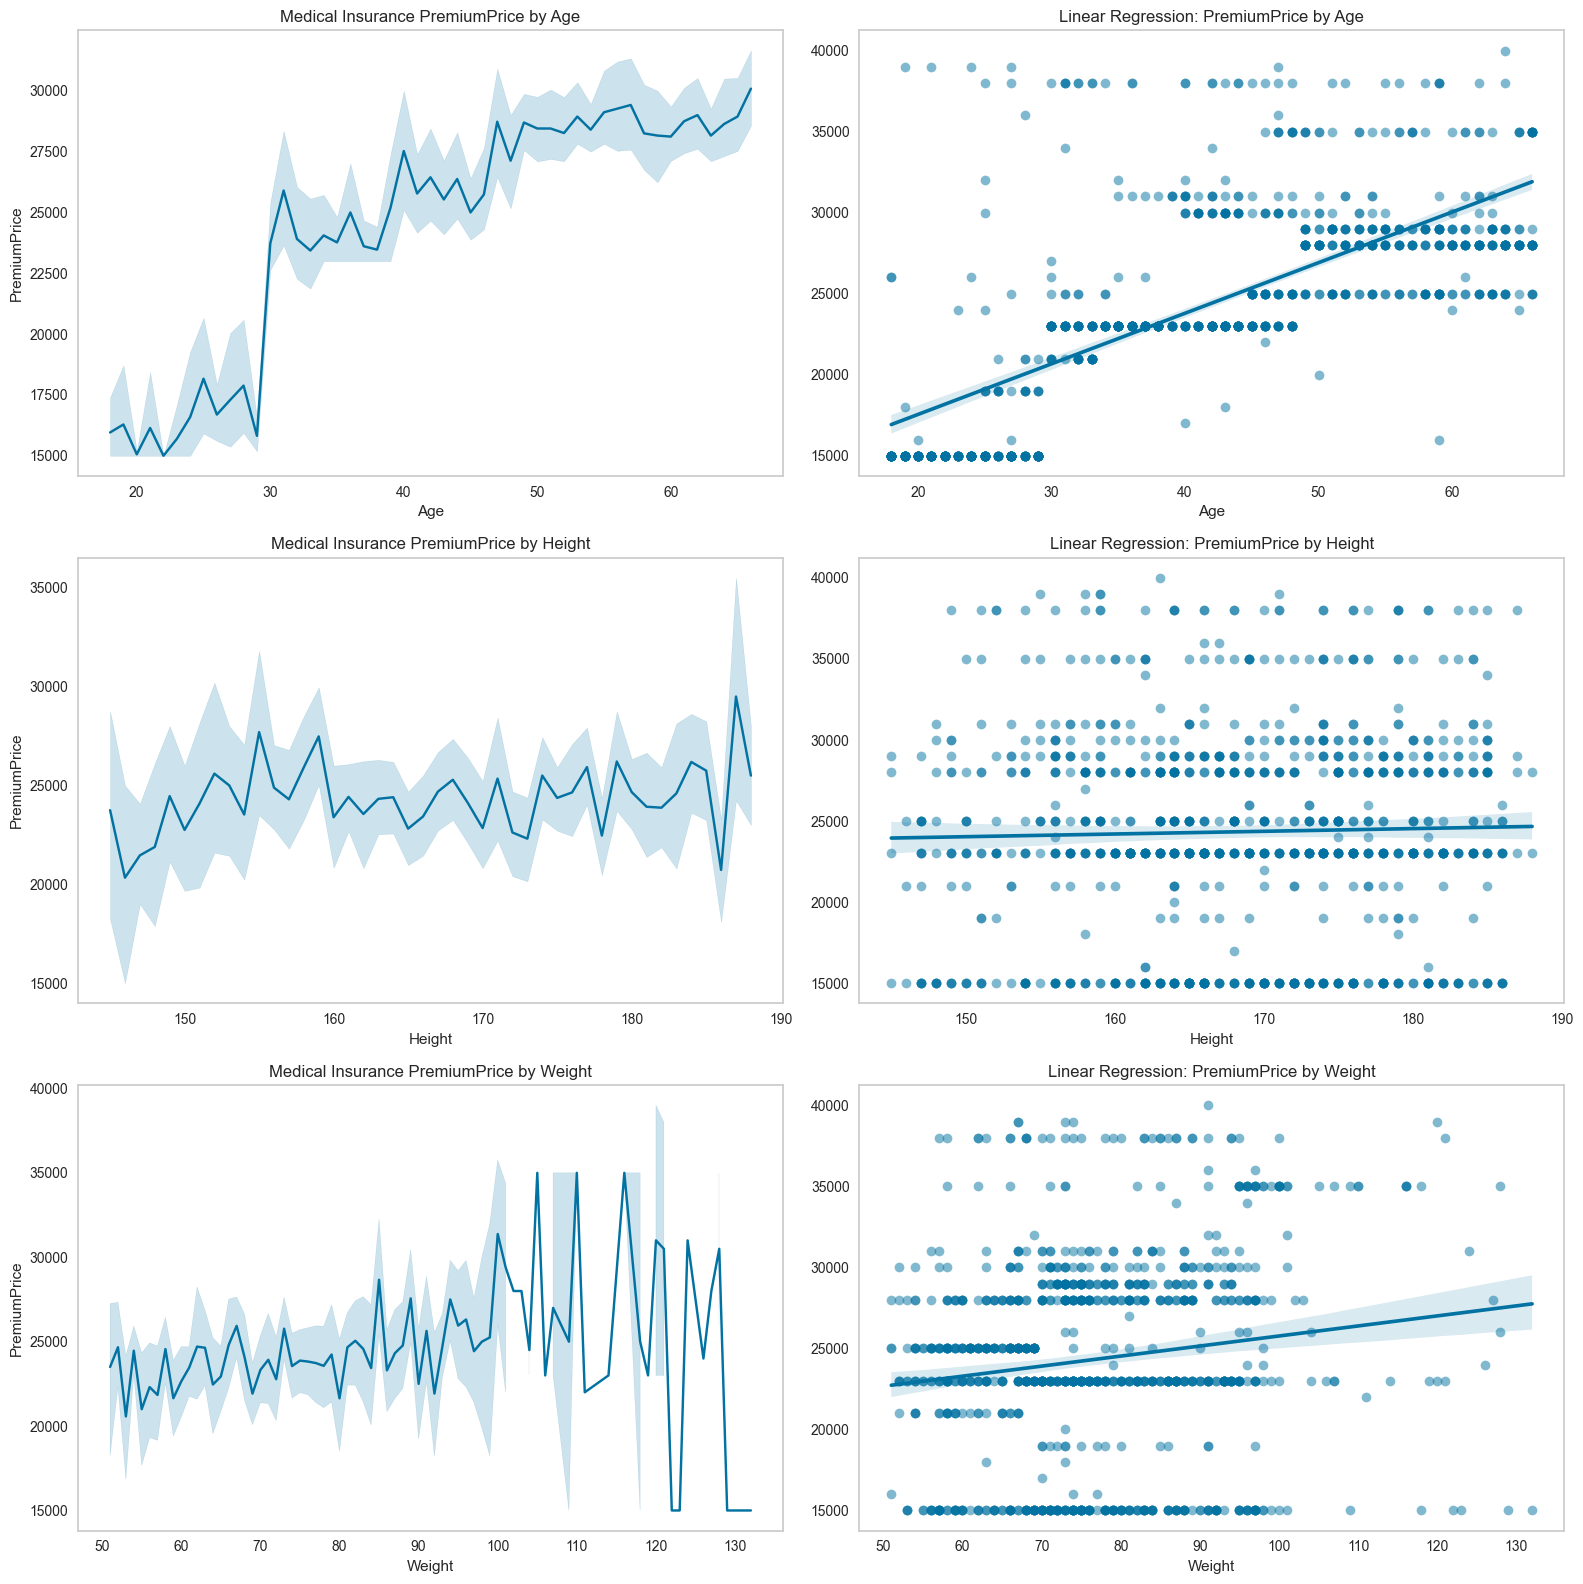

In [24]:
# Line and Lm Plot
obj = ['Age', 'Height', 'Weight']#, 'BMI']

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for i, var in enumerate(obj):
    # Line plot
    sns.lineplot(x=df[var], y=df['PremiumPrice'], ax=ax[i, 0])
    ax[i, 0].set_title(f'Medical Insurance PremiumPrice by {var}')
    ax[i, 0].grid(False)
    
    # lmplot
    sns.regplot(x=var, y='PremiumPrice', data=df, ax=ax[i, 1], scatter_kws={'alpha': 0.5})
    ax[i, 1].set_title(f'Linear Regression: PremiumPrice by {var}')
    ax[i, 1].grid(False)
    ax[i, 1].set_ylabel('')  # Remove the ylabel from lmplot

# Remove unused subplots
for i in range(len(obj), 3):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

We observe that:

As Age increases PremiumPrice(target variable) also increases, The same can be confirmed from the lm plot that there is positive relation between the Age and Premium Price. We also observe some anomalies which might be due to some other factors. In general context as the age increases, chances of health problems also increases and that’s why the premium amount also increases.

As there is very litte to no relation between Height and target variable I am not removing variable as it because Height is a factor in BMI calculation and BMI is consider while setting Premiums.

Life insurance rates are typically higher if you're overweight or obese, since insurers take into account your weight and height when setting premiums. From the plot we observe that the Premium realy fuctuates with weight as we can see some users with lot of weight pay high premium but also there are Users with lot of weight but are paying less premium. 
Overall looking at the regression plot we can say that there is some positive relation between the Premium Price and Weight. If we have more data we might get to see a clearer picture or there might be some other factors influencing the abnormilty.

As per the industry trends Premium Prices are typically higher if you're overweight or obese, since insurers take into account your weight and height when setting premiums.

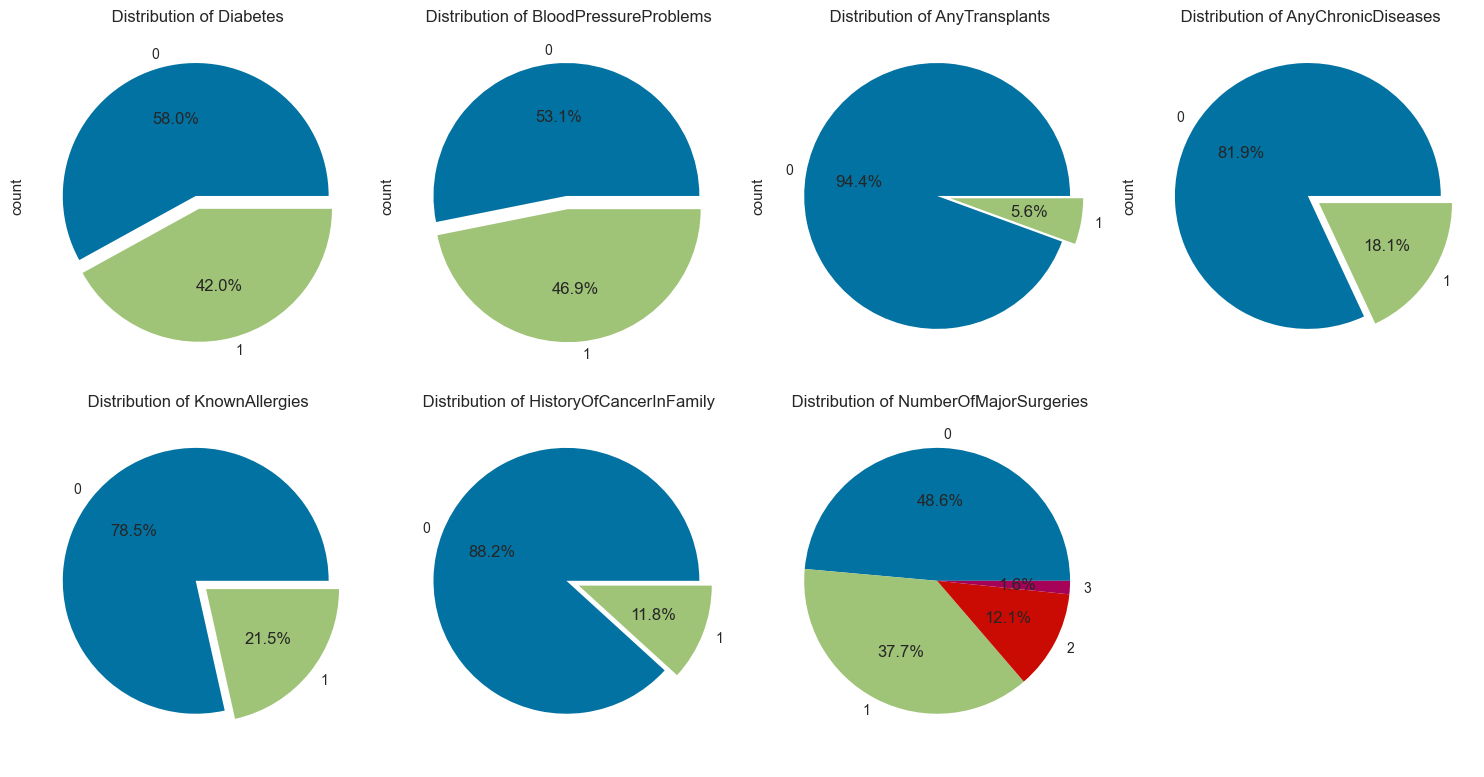

In [25]:
# Pie Plot
variables = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries'] #df[cat] 'BMI_Status',
params = [[0, 0.1], [0, 0.1], [0, 0.1], [0, 0.1], [0, 0.1], [0, 0.1], [0, 0, 0, 0]] #[0, 0, 0, 0],
fig,ax=plt.subplots(nrows=2,ncols=4,figsize=(15,8))
for i, var in enumerate(variables):
    row = i // 4
    col = i % 4
    df[var].value_counts().plot.pie(explode=params[i],autopct='%1.1f%%',ax=ax[row][col])
    ax[row][col].set_title(f' Distribution of {var}')
    ax[row][col].grid(False)
    
# Remove unused subplots
for i in range(len(titles), 2 * 4):
    ax.flatten()[i].axis('off')    
plt.tight_layout() # Adjust layout to optimize space
plt.show()

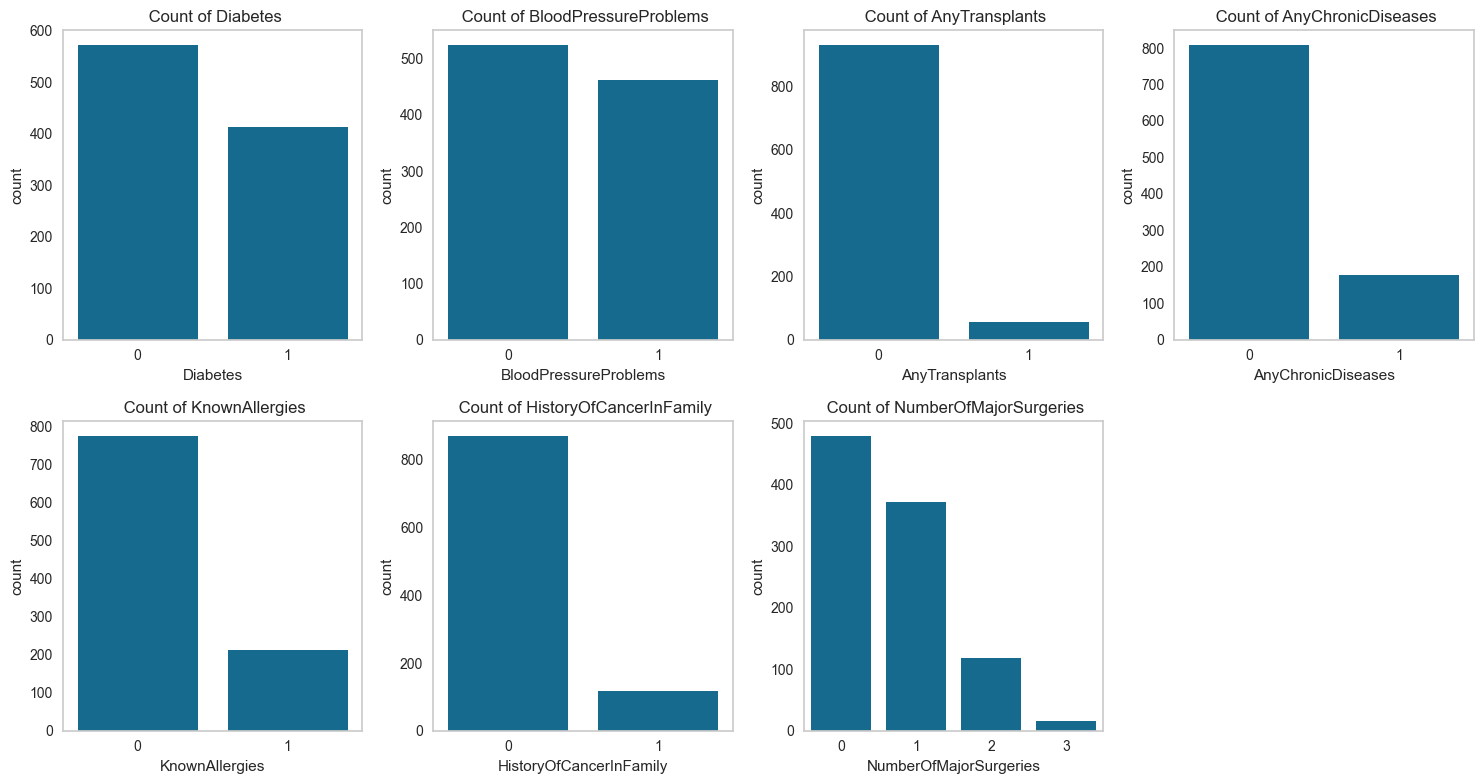

In [26]:
# Count Plot
variables = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries'] #df[cat] 'BMI_Status',
fig,ax=plt.subplots(nrows=2,ncols=4,figsize=(15,8))
for i, var in enumerate(variables):
    row = i // 4
    col = i % 4
    sns.countplot(data = df, x=var, ax=ax[row][col])
    ax[row][col].set_title(f' Count of {var}')
    ax[row][col].grid(False)
    
# Remove unused subplots
for i in range(len(variables), 2 * 4):
    ax.flatten()[i].axis('off')    
plt.tight_layout() # Adjust layout to optimize space
plt.show()

Count of patients with Blood pressure & diabeties is higher than other list of disease and can see the data is collected mostly from patients having these two conditions.

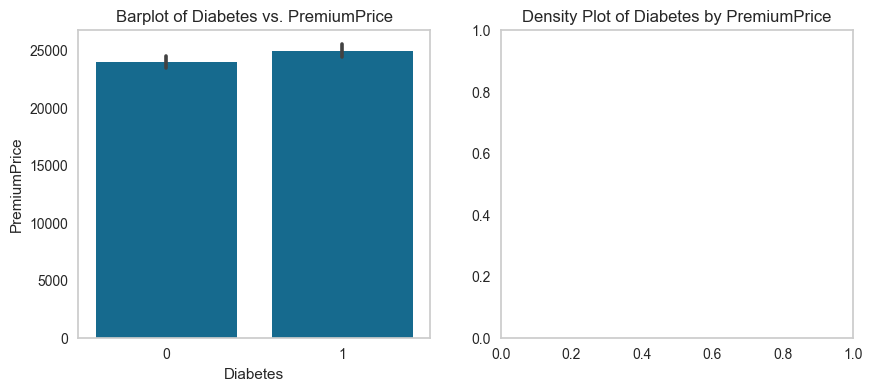

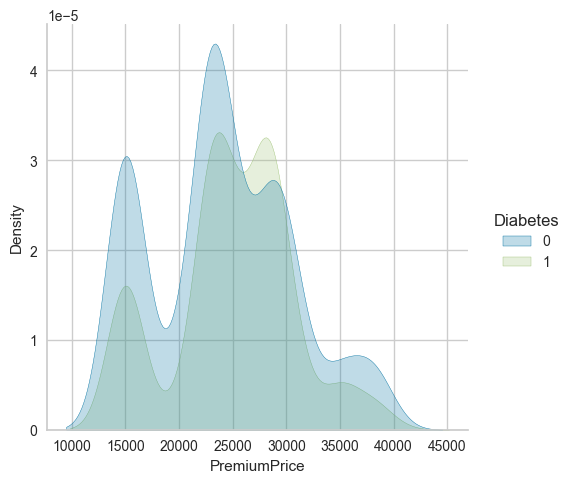

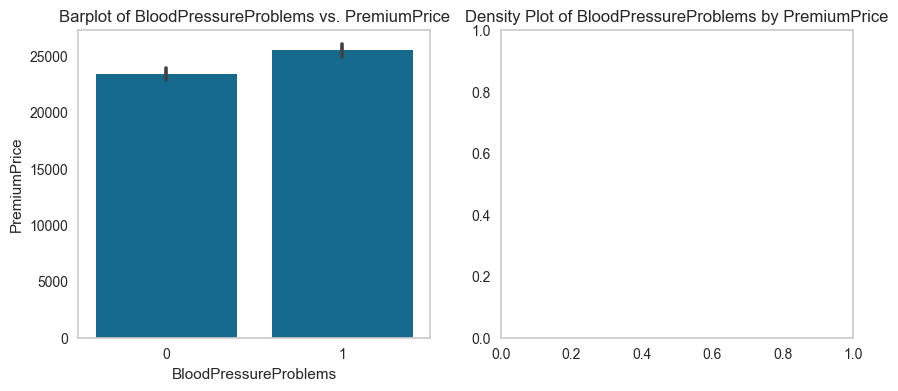

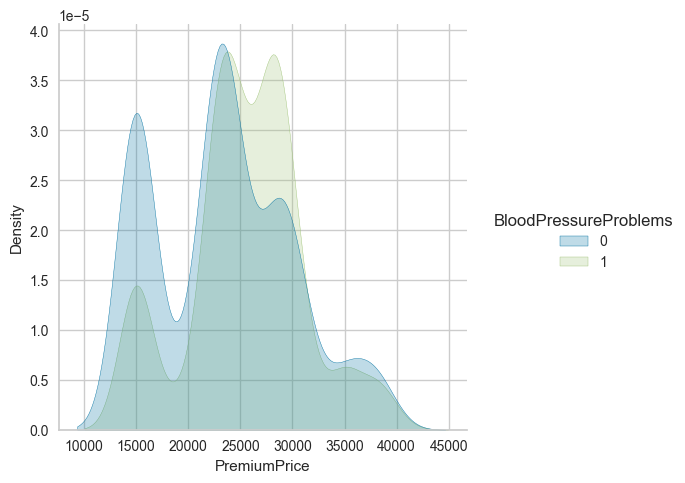

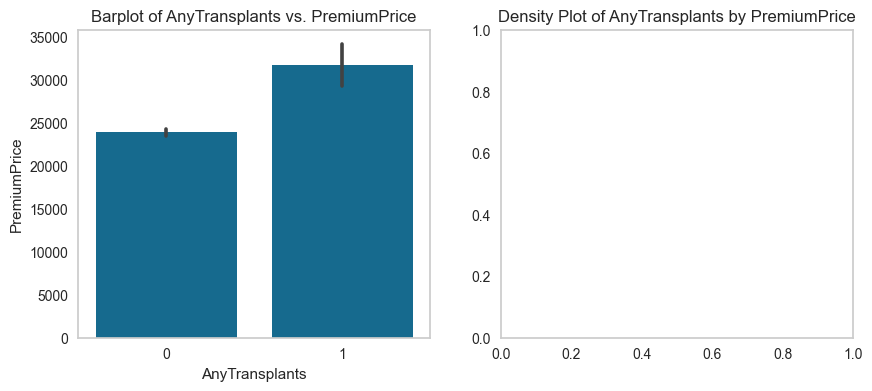

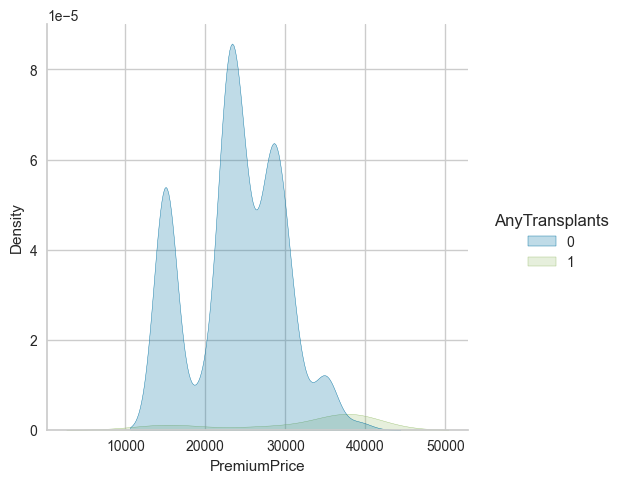

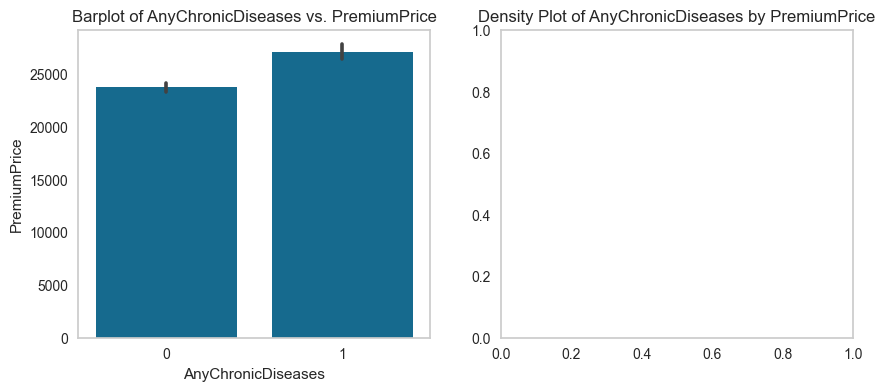

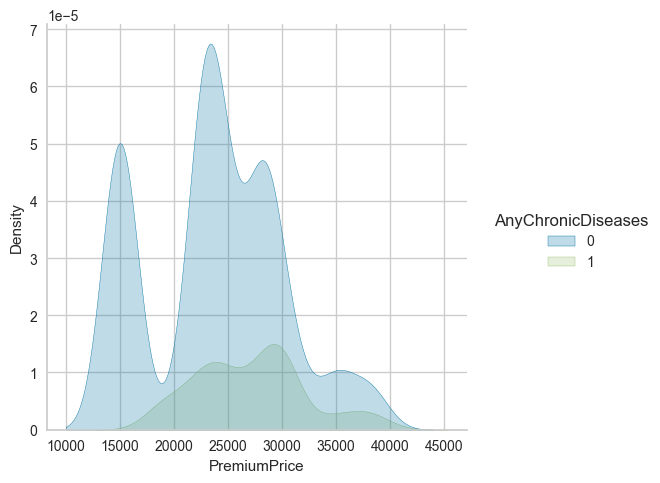

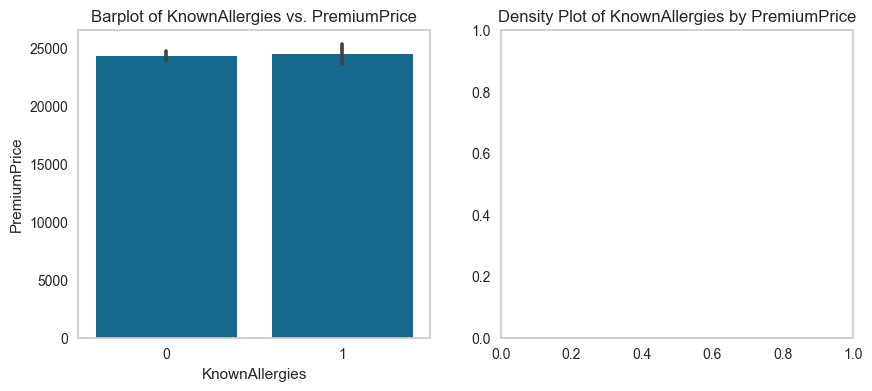

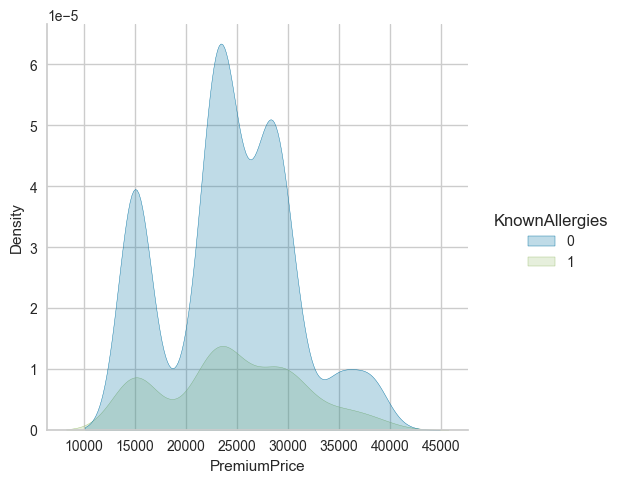

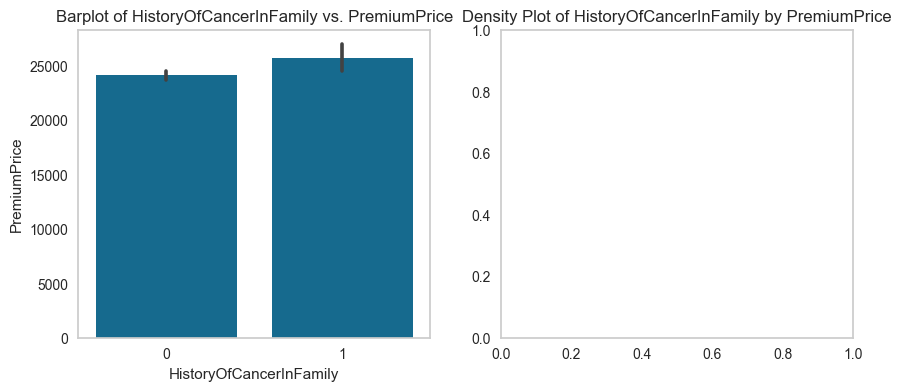

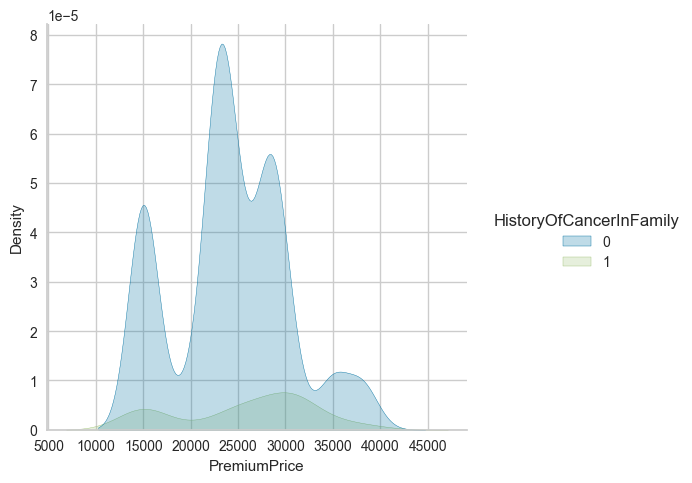

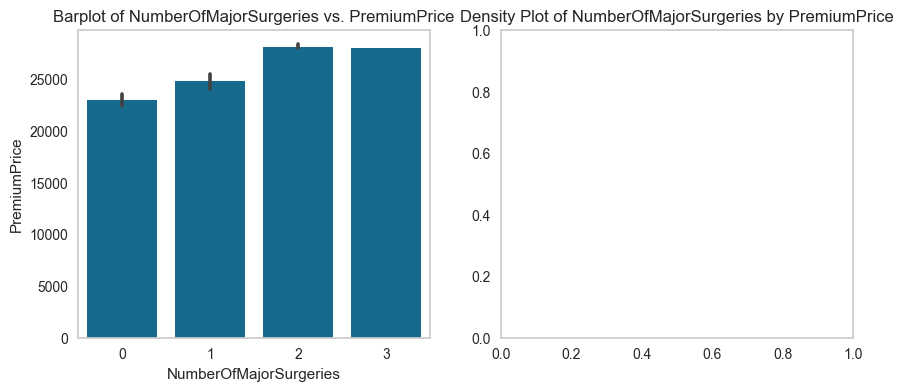

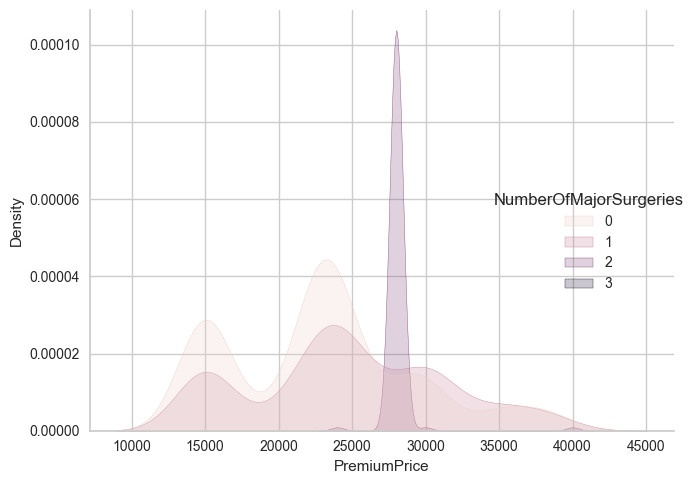

In [27]:
# Barplot with desity Plot
for i in df[cat]:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 4))
    sns.barplot(data = df, x=i, y='PremiumPrice', ax=ax[0])
    sns.displot(data = df, x='PremiumPrice', hue=i, kind="kde", fill=True, ax=ax[1], color='cyan')
    ax[0].set_title(f'Barplot of {i} vs. PremiumPrice')
    ax[1].set_title(f'Density Plot of {i} by PremiumPrice')    
    ax[0].grid(False)
    ax[1].grid(False)
    

plt.tight_layout()
plt.show()

We observe that:

Median Premium Price for Users with Diabetes his Higher than Users without Diabetes but, there are also Users without Diabetes pay much Higher Premium.

Median Premium Price for Users with Blood Pressure Problems his Higher than Users without Blood Pressure Problems but, there are also Users without Blood Pressure Problems Pay Much Higher Premium.

Users with Any Transplant Pay Higer Premium Price.

Users with Any Chronic Diseases pay higher Premium Price.

There is not Much difference in the Premium Price with respect to Users with Known Allergies or NO Allergies.

Users with History of Cancer in Family tend to pay higher Premium Price than the Users who don't.

As the Number of Surgeries increases Premium Price also increases Although the diference is not Significant

Overall, We can say that as person having a disease has higher premium price.

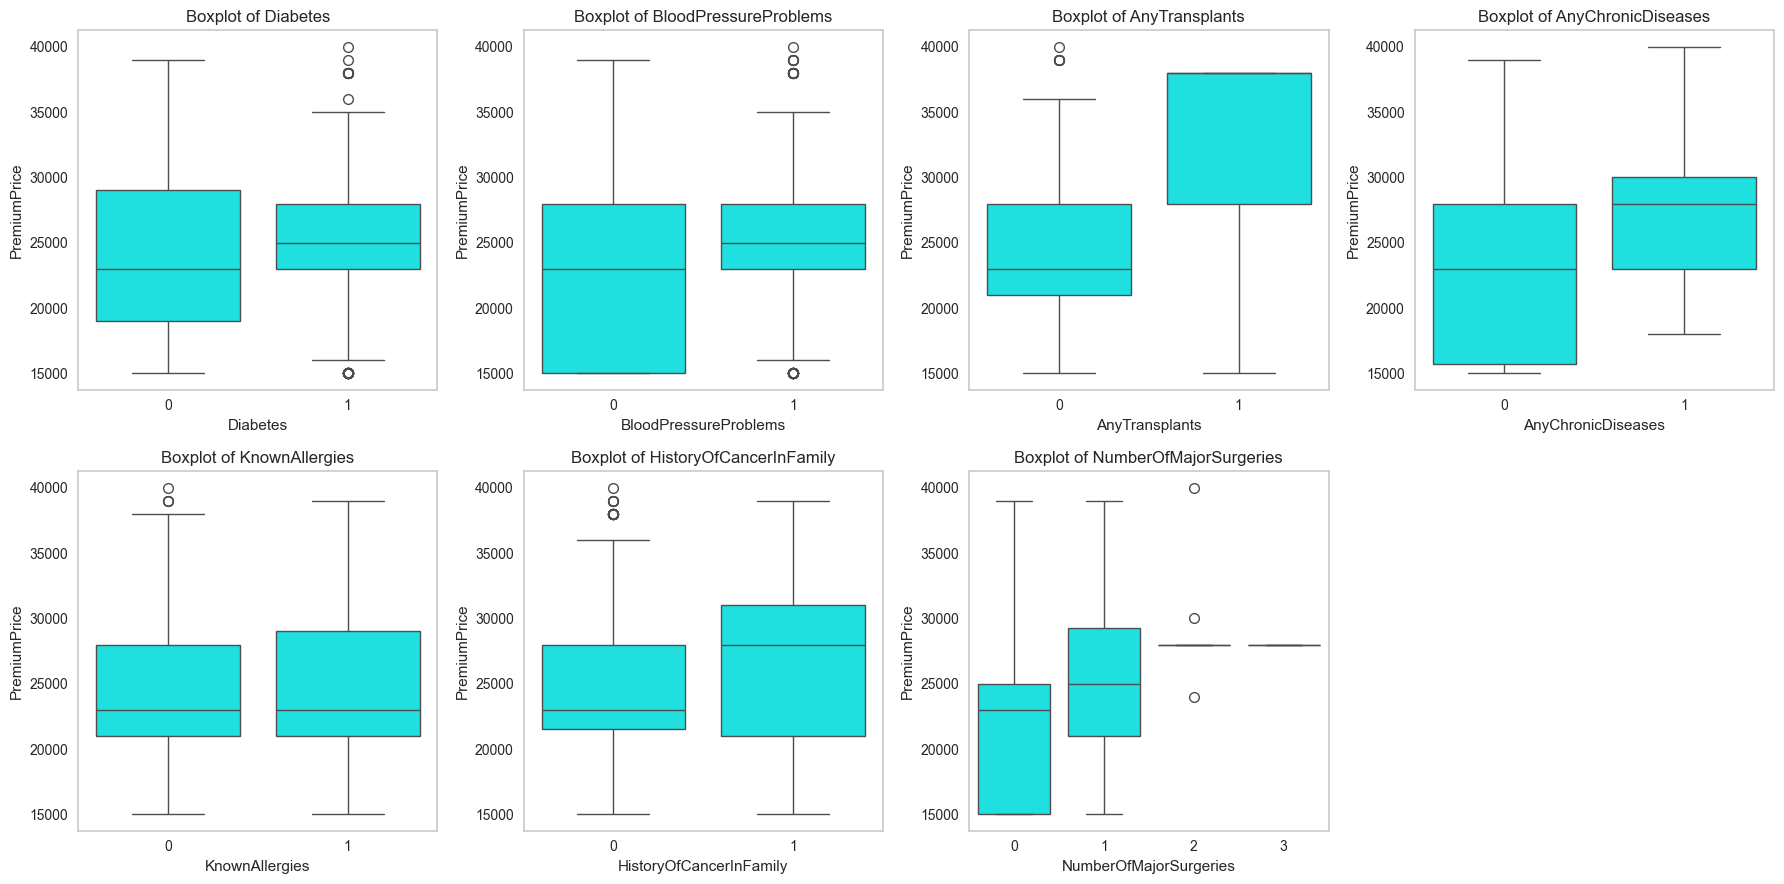

In [28]:
variables = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

# Create a single figure to hold all box plots
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 9))

for i, var in enumerate(variables):
    row = i // 4
    col = i % 4
    
    sns.boxplot(data=df, x=var, y='PremiumPrice', ax=ax[row][col], color='cyan')
    ax[row][col].grid(False)
    ax[row][col].set_title(f'Boxplot of {var}')

# Remove unused subplots
for i in range(len(variables), 2 * 4):
    ax.flatten()[i].axis('off')

# Adjust layout to optimize space
plt.tight_layout()
plt.show()

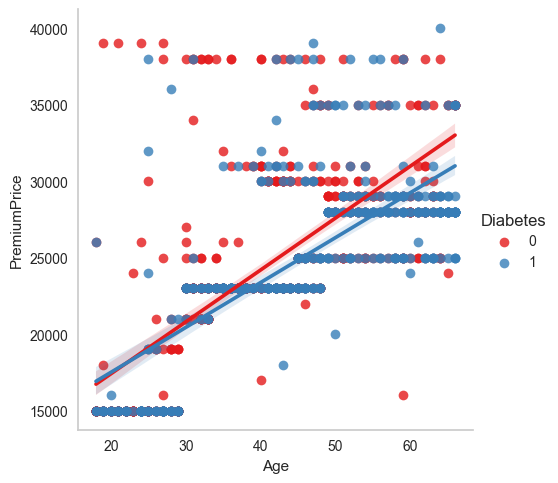

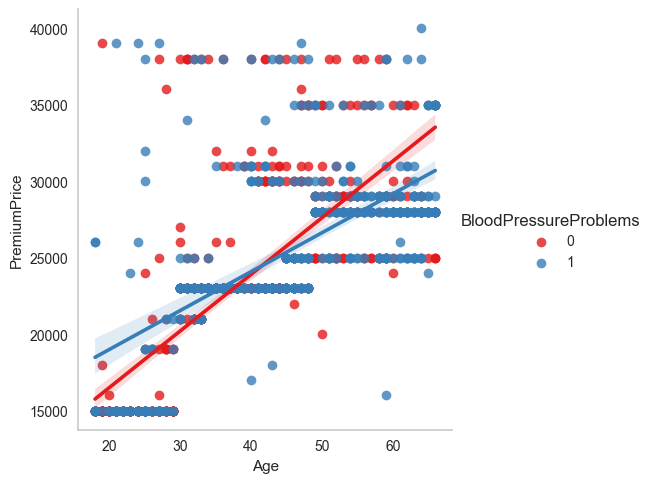

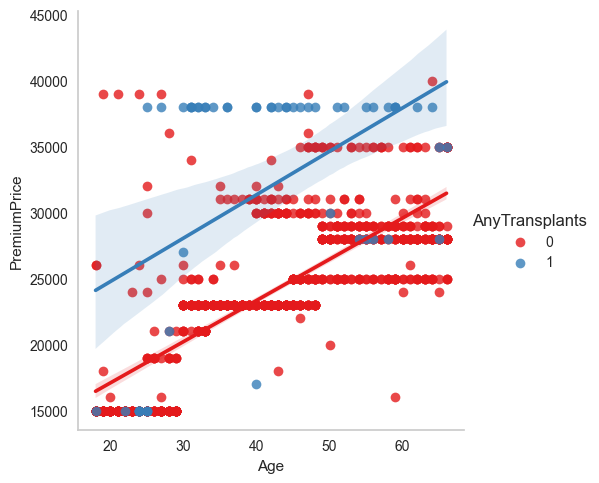

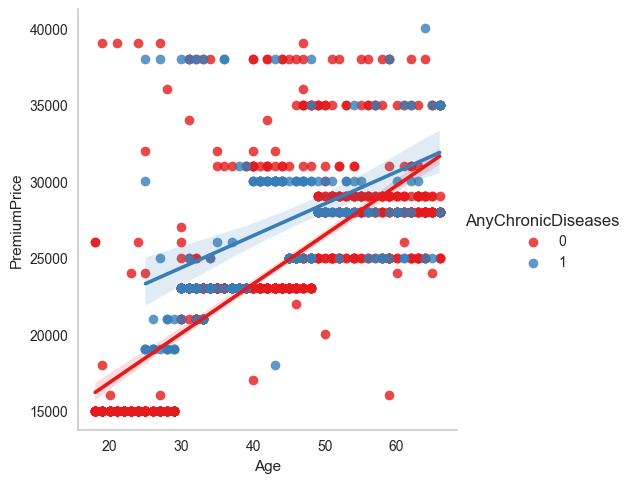

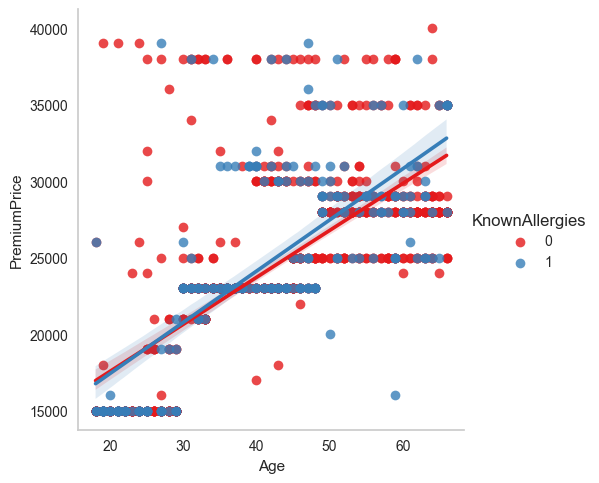

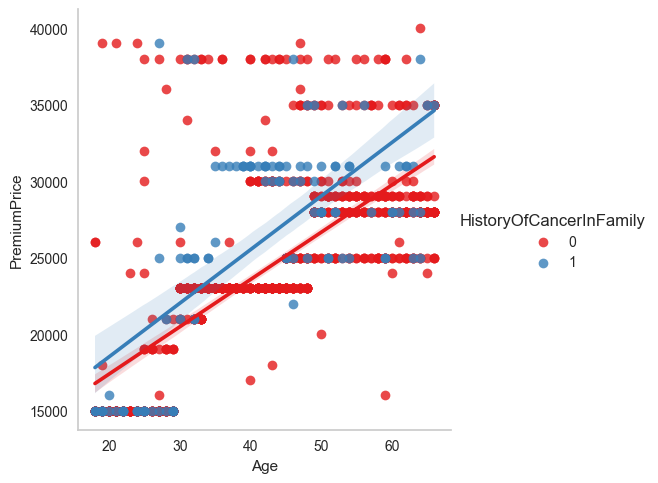

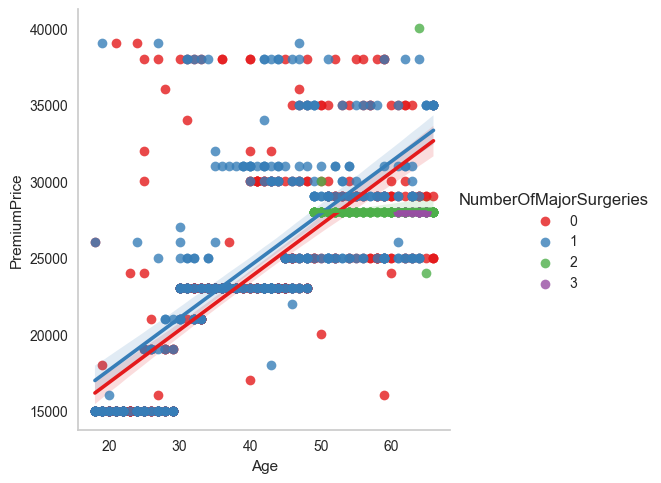

In [29]:
# Lmplot
cat = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries'] #'BMI_Status',
for var in cat:
    sns.lmplot(x='Age', y='PremiumPrice', data=df, hue=var, palette='Set1')
    plt.gca().grid(False)

plt.show()

We observe that:

For younger users, there isn't a significant difference in premium prices between those with diabetes and those without. However, as users age, those with diabetes tend to pay lower premiums compared to those without the condition.

Among younger users, there is a noticeable gap in premium prices between those with blood pressure problems and those without known allergies. As users get older, individuals with blood pressure problems generally pay lower premiums compared to those without such issues.

Users who have undergone any transplant procedure typically face higher premium prices, regardless of their age.

Individuals with any chronic disease typically face higher premium prices compared to those without any chronic conditions. Among younger users, the difference in premiums between those with and without chronic diseases is particularly pronounced, whereas this gap tends to be smaller among older users.

For younger users, there isn't a significant difference in premium prices between those with known allergies and those without. However, as users age, those with known allergies generally pay lower premiums compared to those without such allergies.

As users age, those with a family history of cancer typically pay higher premiums compared to those without such a history. Additionally, while the difference in premium prices between younger users with and without a family history of cancer is relatively small, this difference becomes more significant among older users.

The number of users who have undergone two or three major surgeries is relatively low, and these individuals tend to be older and pay higher premium prices. This suggests a positive relationship between the number of major surgeries and premium prices.

In [30]:
price_cat=['Low','Basic','Average','High','SuperHigh']
df['PremiumLabel']=pr_bins=pd.cut(df['PremiumPrice'],bins=5,labels=price_cat,precision=0)

Text(0.5, 1.0, 'Distribution of the Premium Price by category')

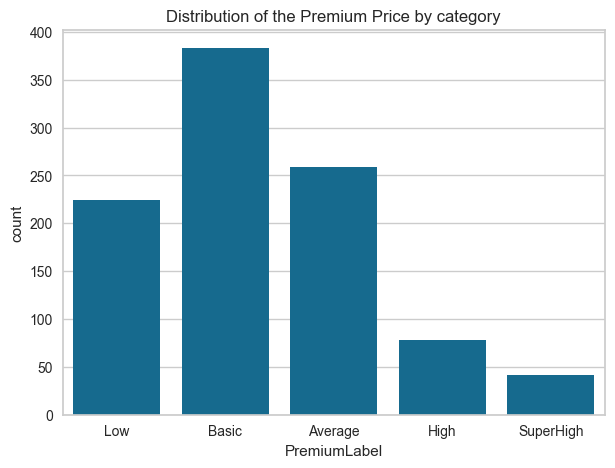

In [31]:
fig,ax=plt.subplots(figsize=(7,5))
sns.countplot(x='PremiumLabel', data=df, ax=ax).set_title('Distribution of the Premium Price by category')

In [32]:
df.groupby(['PremiumLabel','NumberOfMajorSurgeries'])['NumberOfMajorSurgeries'].count()

PremiumLabel  NumberOfMajorSurgeries
Low           0                         142
              1                          82
              2                           0
              3                           0
Basic         0                         226
              1                         156
              2                           1
              3                           0
Average       0                          67
              1                          59
              2                         117
              3                          16
High          0                          22
              1                          56
              2                           0
              3                           0
SuperHigh     0                          22
              1                          19
              2                           1
              3                           0
Name: NumberOfMajorSurgeries, dtype: int64

In [33]:
# Calculating BMI
weight = df['Weight'];
height = df['Height'];

df['BMI'] = 10000*(weight/(height*height))

df.head()

Age Diabetes BloodPressureProblems AnyTransplants AnyChronicDiseases  \
0   45        0                     0              0                  0   
1   60        1                     0              0                  0   
2   36        1                     1              0                  0   
3   52        1                     1              0                  1   
4   38        0                     0              0                  1   

   Height  Weight KnownAllergies HistoryOfCancerInFamily  \
0     155      57              0                       0   
1     180      73              0                       0   
2     158      59              0                       0   
3     183      93              0                       0   
4     166      88              0                       0   

  NumberOfMajorSurgeries  PremiumPrice PremiumLabel        BMI  
0                      0         25000        Basic  23.725286  
1                      0         29000      Average  22.530864  
2                      1         23000        Basic  23.634033  
3                      2         28000      Average  27.770313  
4                      1         23000        Basic  31.934969

In [34]:
df['BMI_Status'] = np.select(
    [df['BMI'] < 18.499999,
     df['BMI'] >= 30,
     df['BMI'].between(18.5, 24.999999),
     df['BMI'].between(25, 29.9999999)],
    ['Underweight', 'Obesse', 'Normal', 'Overweight']
)
df.head()

Age Diabetes BloodPressureProblems AnyTransplants AnyChronicDiseases  \
0   45        0                     0              0                  0   
1   60        1                     0              0                  0   
2   36        1                     1              0                  0   
3   52        1                     1              0                  1   
4   38        0                     0              0                  1   

   Height  Weight KnownAllergies HistoryOfCancerInFamily  \
0     155      57              0                       0   
1     180      73              0                       0   
2     158      59              0                       0   
3     183      93              0                       0   
4     166      88              0                       0   

  NumberOfMajorSurgeries  PremiumPrice PremiumLabel        BMI  BMI_Status  
0                      0         25000        Basic  23.725286      Normal  
1                      0         29000      Average  22.530864      Normal  
2                      1         23000        Basic  23.634033      Normal  
3                      2         28000      Average  27.770313  Overweight  
4                      1         23000        Basic  31.934969      Obesse

In [37]:
df.groupby(['PremiumLabel','BMI_Status'])['BMI_Status'].count()

PremiumLabel  BMI_Status 
Low           Normal          71
              Obesse          70
              Overweight      74
              Underweight      9
Basic         Normal         151
              Obesse          88
              Overweight     120
              Underweight     24
Average       Normal          74
              Obesse          80
              Overweight     100
              Underweight      5
High          Normal          13
              Obesse          49
              Overweight      15
              Underweight      1
SuperHigh     Normal          10
              Obesse          16
              Overweight      16
              Underweight      0
Name: BMI_Status, dtype: int64

<Axes: xlabel='PremiumLabel', ylabel='count'>

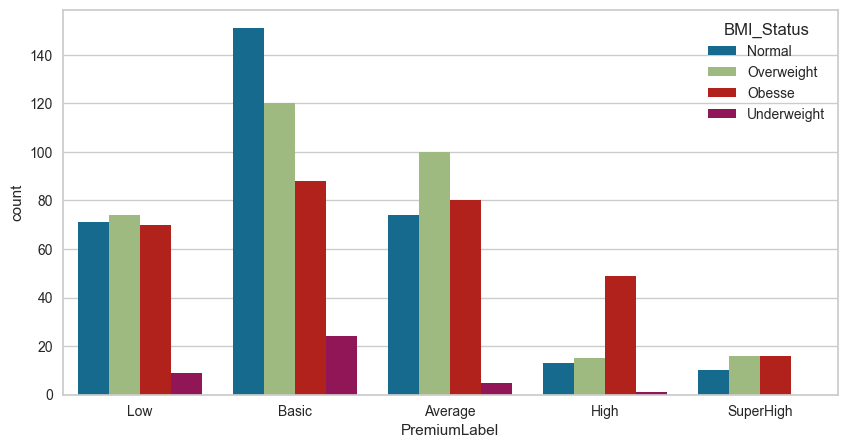

In [35]:
fig,ax=plt.subplots(figsize=(10,5))
sns.countplot(x='PremiumLabel',hue='BMI_Status', data=df,ax=ax)

Text(0.5, 1.0, 'Premium Price by various BMI Status')

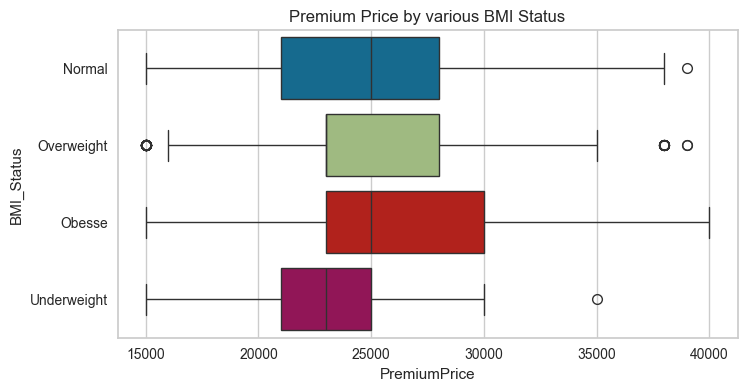

In [36]:
fig,ax=plt.subplots(figsize=(8,4))
sns.boxplot(data=df, x="PremiumPrice", y="BMI_Status", hue="BMI_Status", dodge=False).set_title('Premium Price by various BMI Status')

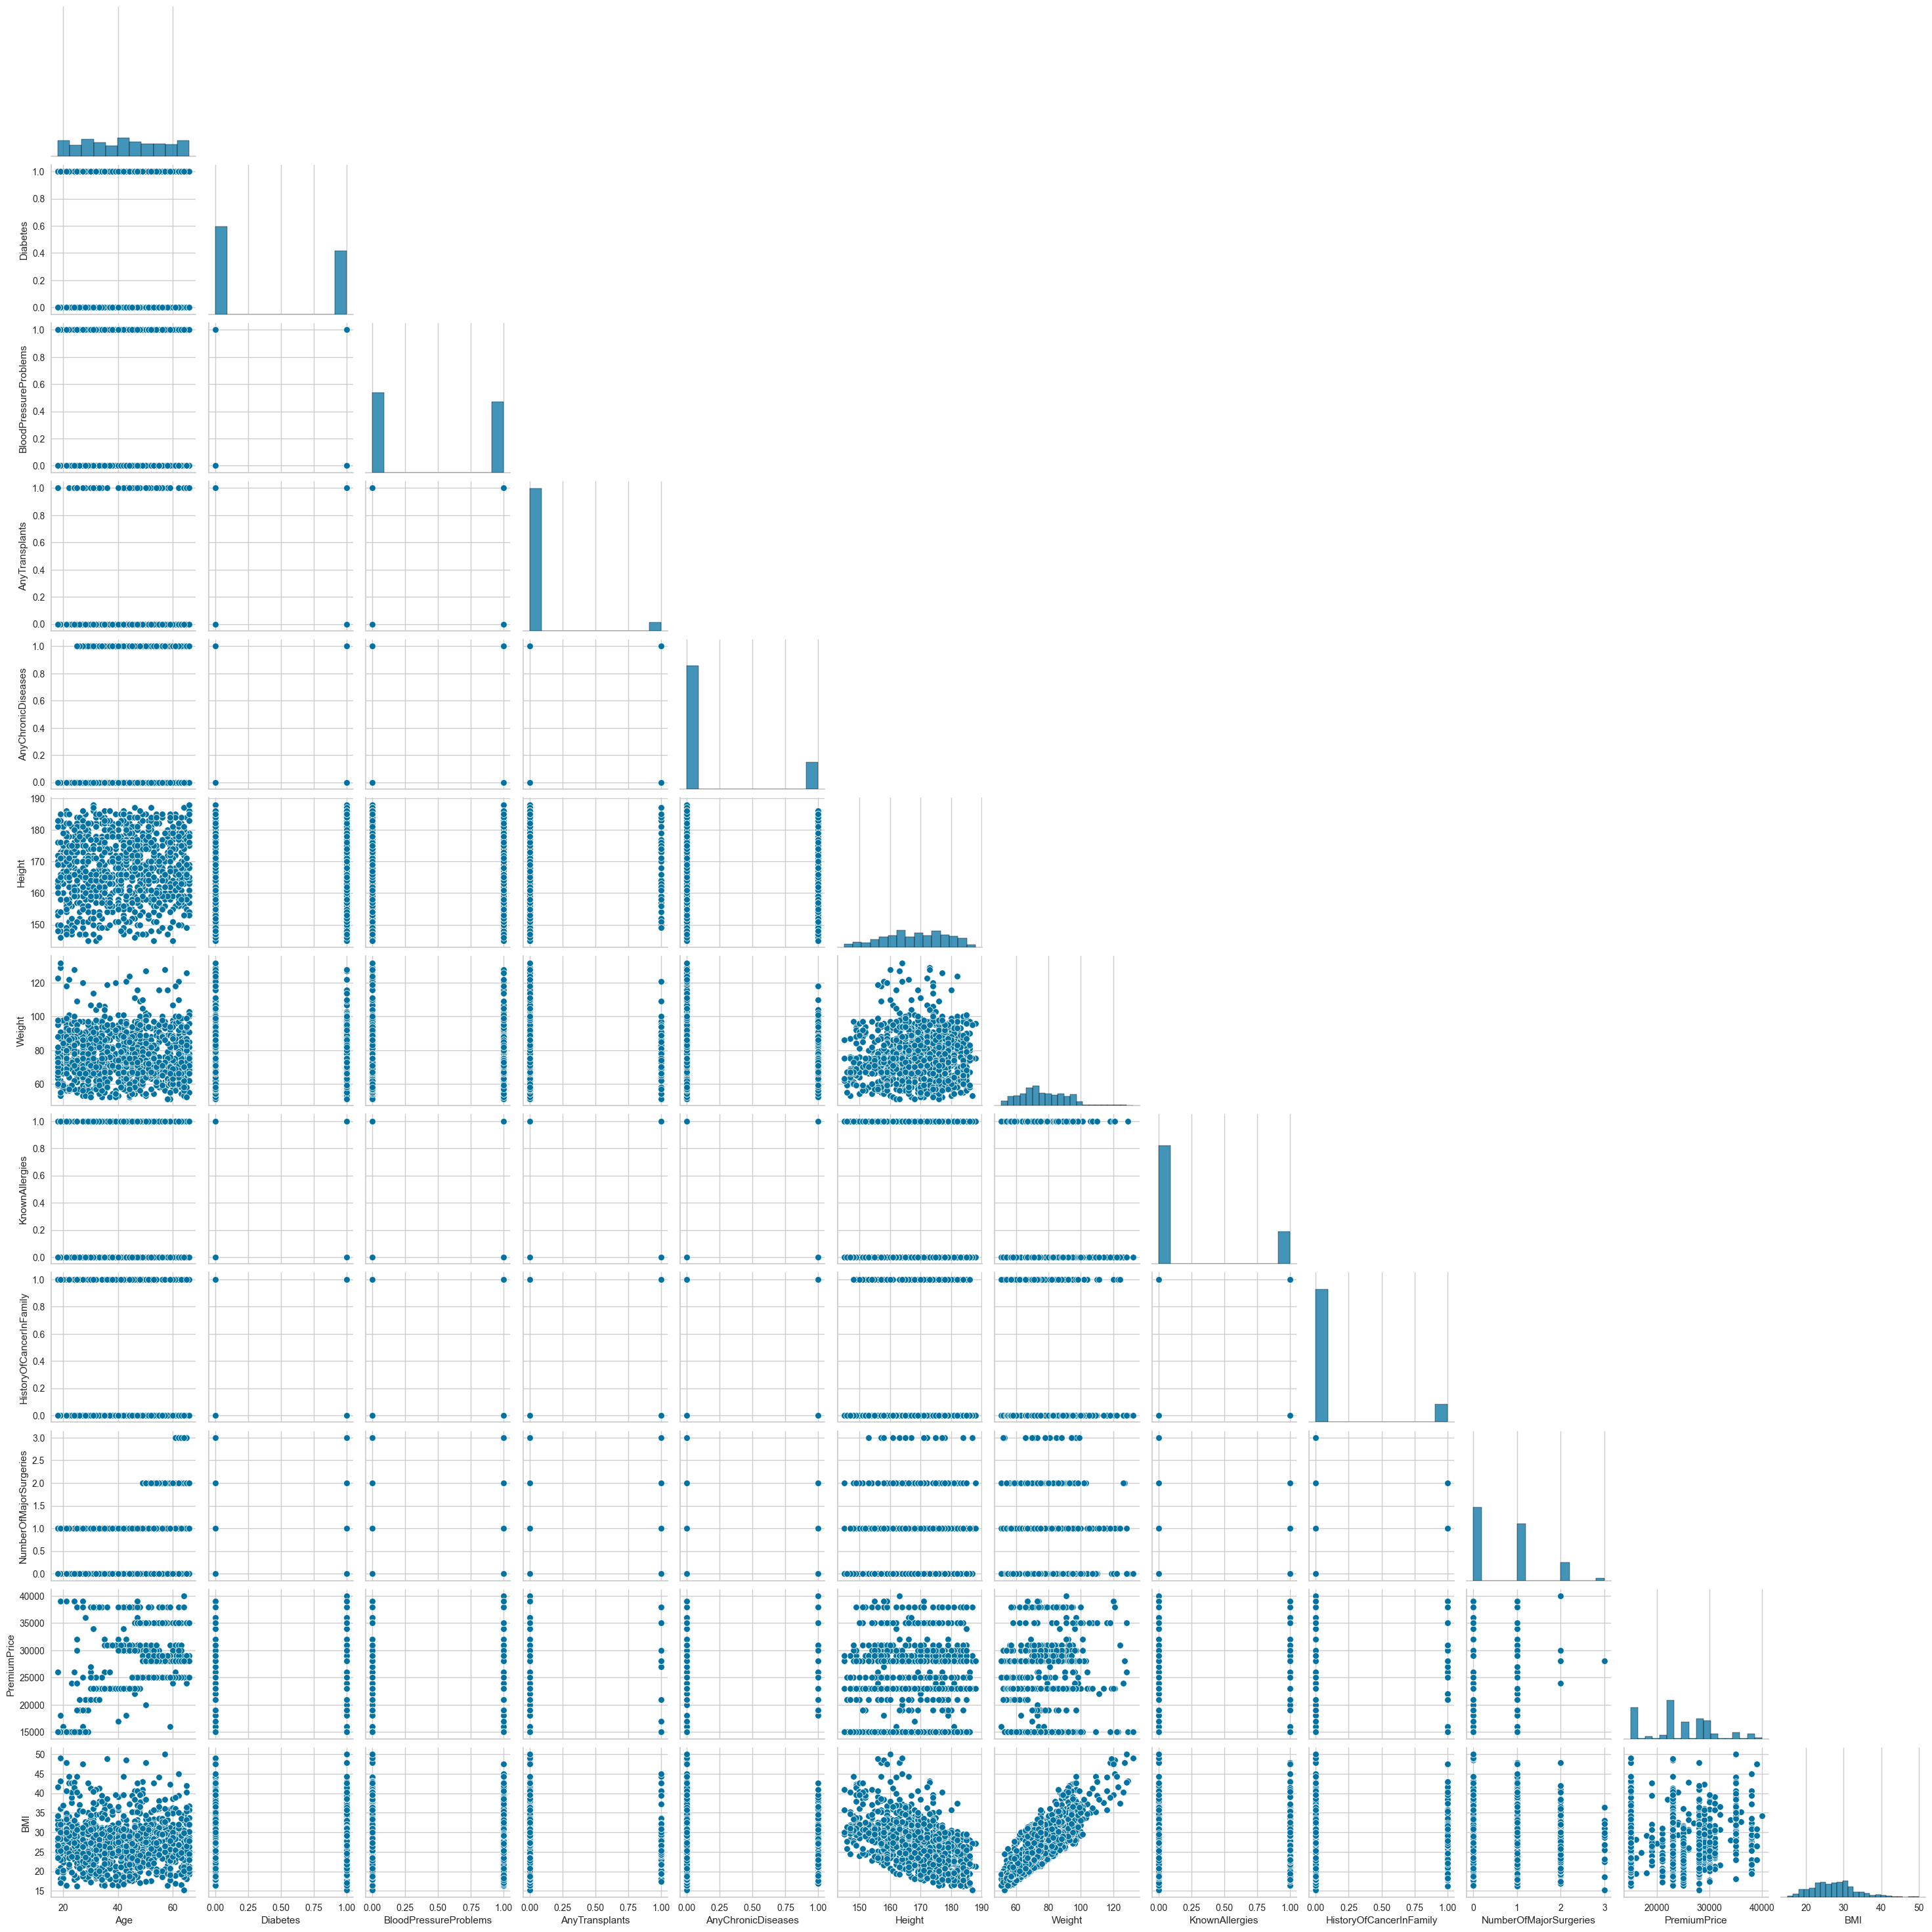

In [37]:
# Pair Plot
#plt.figure(figsize=(14,8))
sns.pairplot(df,corner=True)

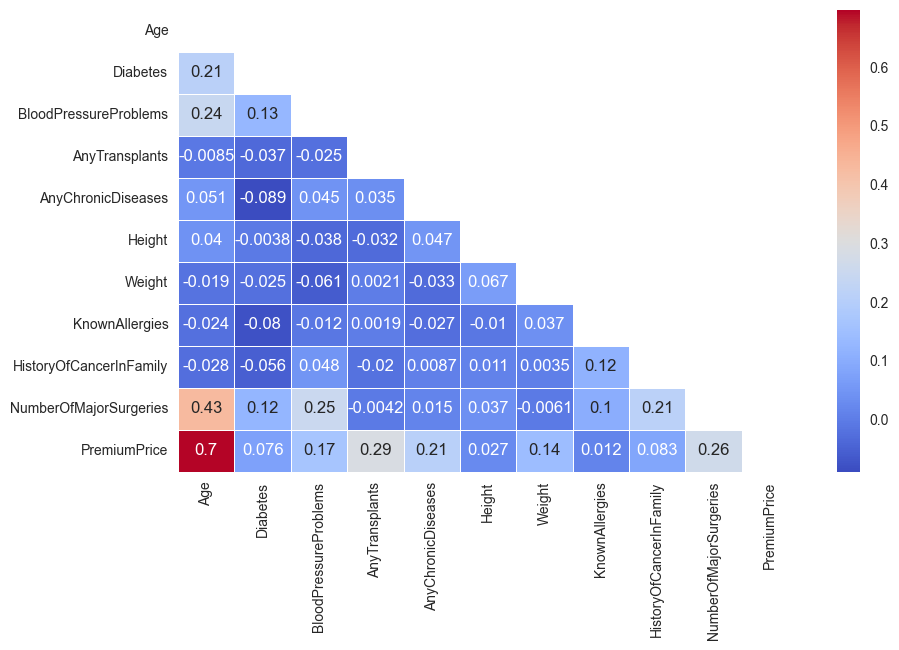

In [38]:
# Heat Map
#from string import ascii_letters
d = pd.DataFrame(data=df, columns=cols)
corr = d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Generate a mask for the upper triangle
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', linewidths=.5)
ax.grid(False)

## Conclusion

### Breakdown of predictors with target variable(PremiumPrice):

1.Age has a strong positive correlation

2.NumberOfMajorSurgeries, AnyChronicDiseases and AnyTransplants also have a moderate positive correlation

3.Other variables have weaker correlations but they might still provide valuable information when combined with other features.

### Based on the above observation factors that play an important role in determining the premium of the user are:

1.Age

2.AnyTransplants

3.AnyChronicDiseases

4.Weight

5.HistoryOfCancerInFamily  

6.NumberOfMajorSurgeries

7.Height


### Below factors have no Impact on the Premium Price:

1.KnownAllergies

2.BloodPressureProblems

3.Diabetes

In [39]:
df=pd.get_dummies(data=df,columns=['BMI_Status'])

In [40]:
df.head()

Age Diabetes BloodPressureProblems AnyTransplants AnyChronicDiseases  \
0   45        0                     0              0                  0   
1   60        1                     0              0                  0   
2   36        1                     1              0                  0   
3   52        1                     1              0                  1   
4   38        0                     0              0                  1   

   Height  Weight KnownAllergies HistoryOfCancerInFamily  \
0     155      57              0                       0   
1     180      73              0                       0   
2     158      59              0                       0   
3     183      93              0                       0   
4     166      88              0                       0   

  NumberOfMajorSurgeries  PremiumPrice PremiumLabel        BMI  \
0                      0         25000        Basic  23.725286   
1                      0         29000      Average  22.530864   
2                      1         23000        Basic  23.634033   
3                      2         28000      Average  27.770313   
4                      1         23000        Basic  31.934969   

   BMI_Status_Normal  BMI_Status_Obesse  BMI_Status_Overweight  \
0               True              False                  False   
1               True              False                  False   
2               True              False                  False   
3              False              False                   True   
4              False               True                  False   

   BMI_Status_Underweight  
0                   False  
1                   False  
2                   False  
3                   False  
4                   False

In [41]:
df.shape

(986, 17)

In [42]:
df.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice',
       'PremiumLabel', 'BMI', 'BMI_Status_Normal', 'BMI_Status_Obesse',
       'BMI_Status_Overweight', 'BMI_Status_Underweight'],
      dtype='object')

In [43]:
# Initialize variables
chi2_values = []
p_values = []
degrees_of_freedom = []
variable_pairs = []

# Loop through pairs of categorical variables
for i in range(len(cat)):
    for n in range(len(cat)):
        if i != n:  # Make sure you're comparing different variables
            table = pd.crosstab(df[cat[i]], df[cat[n]])
            chi2, p, dof, expected = chi2_contingency(table)

            # Store results in lists
            chi2_values.append(chi2)
            p_values.append(p)
            degrees_of_freedom.append(dof)
            variable_pairs.append((cat[i], cat[n]))
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Variable Pair': variable_pairs,
    'Chi-Square Value': chi2_values,
    'P-Value': p_values,
    'Degrees of Freedom': degrees_of_freedom
})

# Print or use the results DataFrame as needed
results_df

Variable Pair  Chi-Square Value  \
0                   (Diabetes, BloodPressureProblems)         15.571225   
1                          (Diabetes, AnyTransplants)          1.020729   
2                      (Diabetes, AnyChronicDiseases)          7.421404   
3                          (Diabetes, KnownAllergies)          5.937673   
4                 (Diabetes, HistoryOfCancerInFamily)          2.700895   
5                  (Diabetes, NumberOfMajorSurgeries)         46.446982   
6                   (BloodPressureProblems, Diabetes)         15.571225   
7             (BloodPressureProblems, AnyTransplants)          0.398749   
8         (BloodPressureProblems, AnyChronicDiseases)          1.804698   
9             (BloodPressureProblems, KnownAllergies)          0.081228   
10   (BloodPressureProblems, HistoryOfCancerInFamily)          2.004172   
11    (BloodPressureProblems, NumberOfMajorSurgeries)         86.123415   
12                         (AnyTransplants, Diabetes)          1.020729   
13            (AnyTransplants, BloodPressureProblems)          0.398749   
14               (AnyTransplants, AnyChronicDiseases)          0.860378   
15                   (AnyTransplants, KnownAllergies)          0.000000   
16          (AnyTransplants, HistoryOfCancerInFamily)          0.174748   
17           (AnyTransplants, NumberOfMajorSurgeries)          0.720517   
18                     (AnyChronicDiseases, Diabetes)          7.421404   
19        (AnyChronicDiseases, BloodPressureProblems)          1.804698   
20               (AnyChronicDiseases, AnyTransplants)          0.860378   
21               (AnyChronicDiseases, KnownAllergies)          0.577858   
22      (AnyChronicDiseases, HistoryOfCancerInFamily)          0.020624   
23       (AnyChronicDiseases, NumberOfMajorSurgeries)          6.108072   
24                         (KnownAllergies, Diabetes)          5.937673   
25            (KnownAllergies, BloodPressureProblems)          0.081228   
26                   (KnownAllergies, AnyTransplants)          0.000000   
27               (KnownAllergies, AnyChronicDiseases)          0.577858   
28          (KnownAllergies, HistoryOfCancerInFamily)         12.269567   
29           (KnownAllergies, NumberOfMajorSurgeries)        109.301702   
30                (HistoryOfCancerInFamily, Diabetes)          2.700895   
31   (HistoryOfCancerInFamily, BloodPressureProblems)          2.004172   
32          (HistoryOfCancerInFamily, AnyTransplants)          0.174748   
33      (HistoryOfCancerInFamily, AnyChronicDiseases)          0.020624   
34          (HistoryOfCancerInFamily, KnownAllergies)         12.269567   
35  (HistoryOfCancerInFamily, NumberOfMajorSurgeries)        160.282232   
36                 (NumberOfMajorSurgeries, Diabetes)         46.446982   
37    (NumberOfMajorSurgeries, BloodPressureProblems)         86.123415   
38           (NumberOfMajorSurgeries, AnyTransplants)          0.720517   
39       (NumberOfMajorSurgeries, AnyChronicDiseases)          6.108072   
40           (NumberOfMajorSurgeries, KnownAllergies)        109.301702   
41  (NumberOfMajorSurgeries, HistoryOfCancerInFamily)        160.282232   

         P-Value  Degrees of Freedom  
0   7.945461e-05                   1  
1   3.123461e-01                   1  
2   6.445249e-03                   1  
3   1.482058e-02                   1  
4   1.002919e-01                   1  
5   4.556699e-10                   3  
6   7.945461e-05                   1  
7   5.277361e-01                   1  
8   1.791456e-01                   1  
9   7.756406e-01                   1  
10  1.568669e-01                   1  
11  1.489349e-18                   3  
12  3.123461e-01                   1  
13  5.277361e-01                   1  
14  3.536330e-01                   1  
15  1.000000e+00                   1  
16  6.759265e-01                   1  
17  8.683679e-01                   3  
18  6.445249e-03                   1  
19  1.791456e-01                  

# Building the ML models

In [44]:
x=df.drop(['PremiumPrice', 'PremiumLabel', 'Height', 'Weight', 'BMI_Status_Normal', 'BMI_Status_Obesse', 'BMI_Status_Overweight', 'BMI_Status_Underweight'], axis=1)
y=df['PremiumPrice']

In [45]:
x.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily',
       'NumberOfMajorSurgeries', 'BMI'],
      dtype='object')

### Data Normalization

In [46]:
sc=StandardScaler()
xsc=sc.fit_transform(x)

In [47]:
xsc=pd.DataFrame(xsc,columns=x.columns)

In [48]:
mi_scores = mutual_info_regression(xsc,y)
mi_scores = pd.Series(mi_scores, name="MI Scores",index=xsc.columns)
mi_scores = mi_scores.sort_values(ascending=False)
(mi_scores*100).head(15).index

Index(['Age', 'NumberOfMajorSurgeries', 'AnyChronicDiseases', 'AnyTransplants',
       'HistoryOfCancerInFamily', 'BMI', 'Diabetes', 'BloodPressureProblems',
       'KnownAllergies'],
      dtype='object')

In [49]:
fea=list((mi_scores*100).head(15).index)
xsc=xsc[fea]
xsc

Age  NumberOfMajorSurgeries  AnyChronicDiseases  AnyTransplants  \
0    0.233197               -0.891187           -0.469358       -0.243056   
1    1.307981               -0.891187           -0.469358       -0.243056   
2   -0.411674                0.444239           -0.469358       -0.243056   
3    0.734763                1.779665            2.130569       -0.243056   
4   -0.268369                0.444239            2.130569       -0.243056   
..        ...                     ...                 ...             ...   
981 -1.701415               -0.891187           -0.469358       -0.243056   
982  1.594590                3.115090           -0.469358       -0.243056   
983  1.021372                0.444239           -0.469358       -0.243056   
984  0.376502                0.444239           -0.469358       -0.243056   
985 -1.486458                0.444239           -0.469358       -0.243056   

     HistoryOfCancerInFamily       BMI  Diabetes  BloodPressureProblems  \
0                  -0.365148 -0.635742 -0.850750              -0.938978   
1                  -0.365148 -0.839024  1.175433              -0.938978   
2                  -0.365148 -0.651273  1.175433               1.064988   
3                  -0.365148  0.052692  1.175433               1.064988   
4                  -0.365148  0.761487 -0.850750              -0.938978   
..                       ...       ...       ...                    ...   
981                -0.365148 -0.681136 -0.850750              -0.938978   
982                -0.365148  0.415665  1.175433               1.064988   
983                -0.365148  0.356016 -0.850750               1.064988   
984                -0.365148  0.303181  1.175433               1.064988   
985                -0.365148  0.439532 -0.850750              -0.938978   

     KnownAllergies  
0         -0.523356  
1         -0.523356  
2         -0.523356  
3         -0.523356  
4         -0.523356  
..              ...  
981       -0.523356  
982       -0.523356  
983       -0.523356  
984        1.910744  
985        1.910744  

[986 rows x 9 columns]

In [50]:
y.shape

(986,)

### Split train

In [51]:
l1=[]
l2=[]
l3=[]
cvs=0
for i in range(40,50):
    xtrain,xtest,ytrain,ytest=train_test_split(xsc, y, random_state=i, test_size=0.25)
    lrmodel=LinearRegression()
    lrmodel.fit(xtrain,ytrain)
    l1.append(lrmodel.score(xtrain,ytrain))
    l2.append(lrmodel.score(xtest,ytest))
    cvs=(cross_val_score(lrmodel,xsc,y,cv=5,)).mean()
    l3.append(cvs)
    df1=pd.DataFrame({'train Acc':l1,'test Acc':l2,'cv_score':l3})
df1

train Acc  test Acc  cv_score
0   0.637474  0.627533  0.625563
1   0.611197  0.708565  0.625563
2   0.611934  0.684631  0.625563
3   0.618526  0.678363  0.625563
4   0.663599  0.538531  0.625563
5   0.612477  0.693333  0.625563
6   0.623898  0.664788  0.625563
7   0.624509  0.663170  0.625563
8   0.619543  0.675309  0.625563
9   0.674919  0.501717  0.625563

##  Linear Regression Model

train Acc: 0.6111971888559355
test Acc: 0.7085652213125866
cv_score: 0.6255626958404497


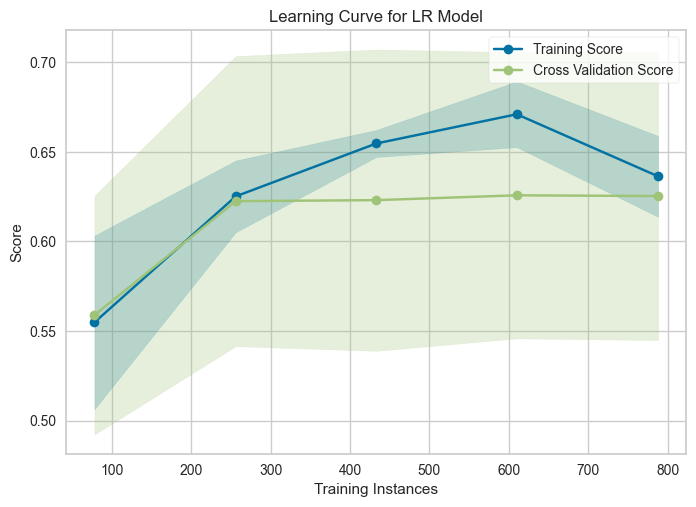

<Axes: title={'center': 'Learning Curve for LR Model'}, xlabel='Training Instances', ylabel='Score'>

In [53]:
xtrain,xtest,ytrain,ytest=train_test_split(xsc,y,test_size=0.25,random_state=41)
lrmodel=LinearRegression()
lrmodel.fit(xtrain,ytrain)

# Predict the target variable for the train, test data
ypredtrain = lrmodel.predict(xtrain)
ypredtest = lrmodel.predict(xtest)

print(f'train Acc: {r2_score(ytrain,ypredtrain)}')
print(f'test Acc: {r2_score(ytest,ypredtest)}')
print(f'cv_score: {cross_val_score(lrmodel,xsc,y,cv=5,).mean()}')


visualizer = learning_curve(lrmodel,xsc,y,cv=5, scoring='r2', title="Learning Curve for LR Model")
visualizer.show()

## Random Forest

In [56]:
start_time = time.time()
rfmodel0=RandomForestRegressor(random_state=41)
rfmodel0.fit(xtrain,ytrain)
ypredtrain2=rfmodel0.predict(xtrain)
ypredtest2=rfmodel0.predict(xtest)
print(f'train Acc: {r2_score(ytrain,ypredtrain2)}')
print(f'test Acc: {r2_score(ytest,ypredtest2)}')
print(f'cv_score: {cross_val_score(rfmodel0,xsc,y,cv=5,).mean()}\n')

estimator=RandomForestRegressor(random_state=41)
param_grid={'n_estimators':[40, 60, 220, 570]}
grid1=GridSearchCV(estimator,param_grid,scoring="r2",cv=5)
grid1.fit(xtrain,ytrain)
print(grid1.best_params_)

rfmodel=grid1
rfmodel.fit(xtrain,ytrain)
ypredtrain2=rfmodel.predict(xtrain)
ypredtest2=rfmodel.predict(xtest)
acc_RF_Train = (r2_score(ytrain,ypredtrain2))
print('train Acc:', acc_RF_Train)
acc_RF_Test = (r2_score(ytest,ypredtest2))
print('test Acc:', acc_RF_Test)
acc_RF_CV = cross_val_score(rfmodel,xsc,y,cv=5,).mean()
print('cv_score:', acc_RF_CV)

# other metrics
MAE_RF_Test= metrics.mean_absolute_error(ytest,ypredtest2)
print('MAE:',MAE_RF_Test)
MSE_RF_Test = metrics.mean_squared_error(ytest,ypredtest2)
print('MSE:',MSE_RF_Test)
RMSE_RF_Test = np.sqrt(metrics.mean_squared_error(ytest,ypredtest2))
print('RMSE:', RMSE_RF_Test)
MAPE_RF_Test= (metrics.mean_absolute_percentage_error(ytest,ypredtest2))
print('MAPE:',MAPE_RF_Test)

end_time = time.time()
RF_elapsed_time = end_time - start_time
print(f"Elapsed Time: {RF_elapsed_time} seconds")

train Acc: 0.9555041911092462
test Acc: 0.8437573879405865
cv_score: 0.7342771613420176

{'n_estimators': 570}
train Acc: 0.9577424786114702
test Acc: 0.8441182800297784
cv_score: 0.7342023573799132
MAE: 1373.1586050145606
MSE: 5737174.976292924
RMSE: 2395.240066526302
MAPE: 0.05806255054099174
Elapsed Time: 138.52002239227295 seconds


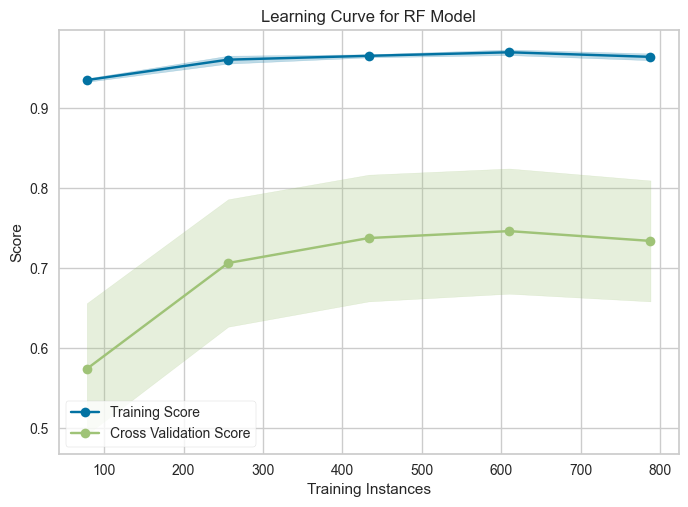

<Axes: title={'center': 'Learning Curve for RF Model'}, xlabel='Training Instances', ylabel='Score'>

In [59]:
# Learning Curve
visualizer = learning_curve(rfmodel,xsc,y,cv=5, scoring='r2', title="Learning Curve for RF Model")
visualizer.show()

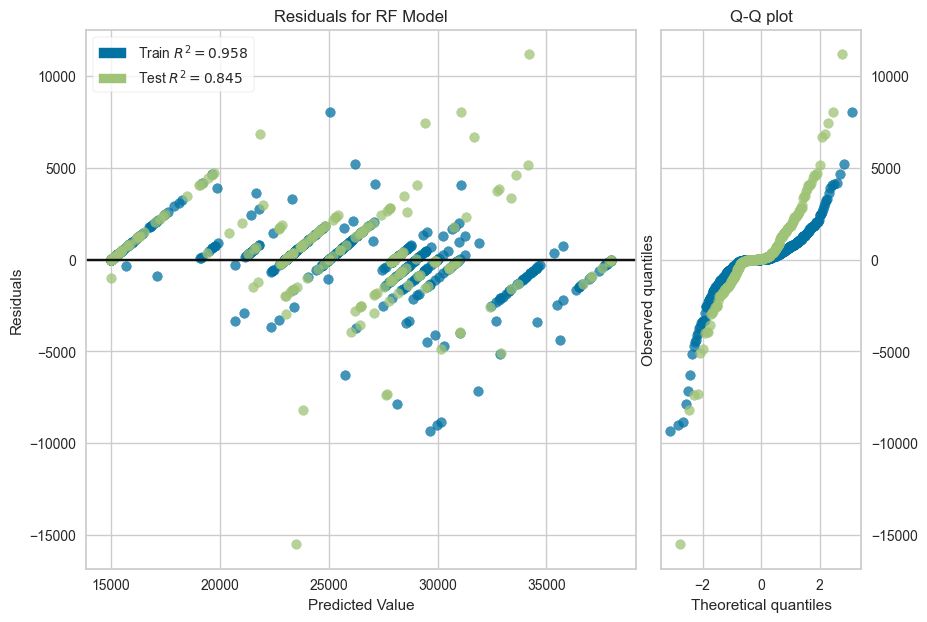

In [60]:
# Residuals plot and Q-Q plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = residuals_plot(estimator=rfmodel,
                   is_fitted=True,
                   ax=ax,
                   X_train=xtrain,
                   y_train=ytrain,
                   X_test=xtest,
                   y_test=ytest,
                   hist=False,
                   qqplot=True,
                  title="Residuals for RF Model"
                  )

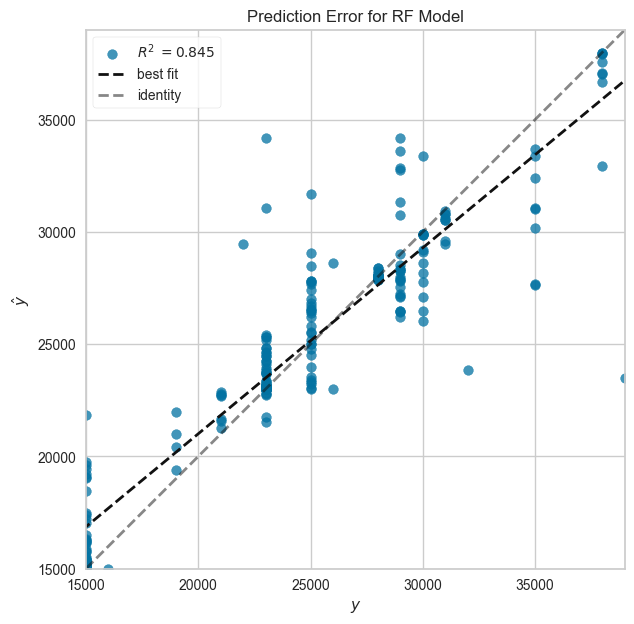

In [61]:
# Prediction error plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = prediction_error(estimator=rfmodel,
                     is_fitted=True,
                     ax=ax,
                     X_train=xtrain,
                     y_train=ytrain,
                     X_test=xtest,
                     y_test=ytest,
                     title="Prediction Error for RF Model")

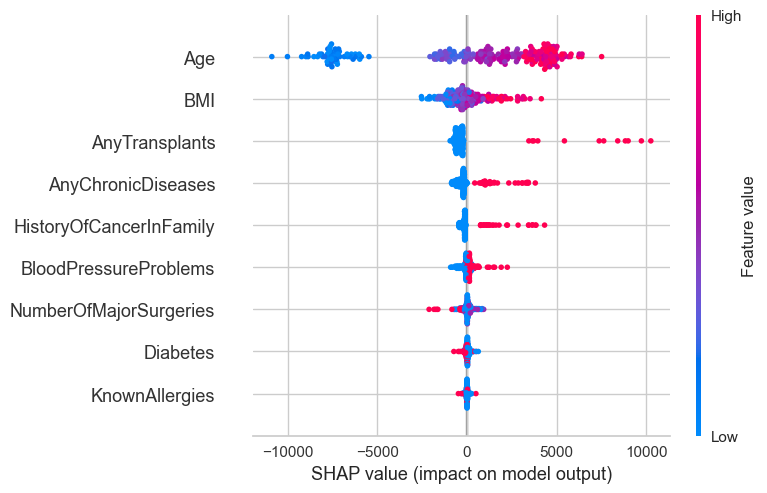

In [62]:
# SHAP Analysis
explainer1 = shap.TreeExplainer(rfmodel0)
RF_shap_values = explainer1.shap_values(xtest)
shap.summary_plot(RF_shap_values, xtest)

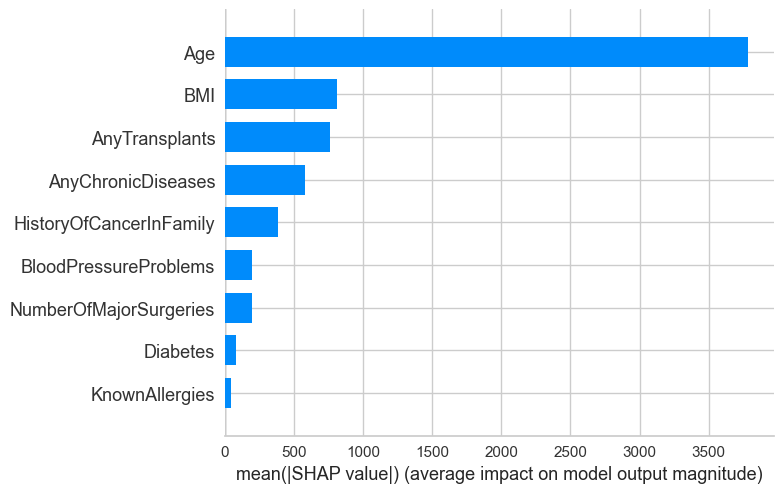

In [63]:
shap.summary_plot(RF_shap_values, xtest, plot_type="bar")

In [64]:
xtest.columns

Index(['Age', 'NumberOfMajorSurgeries', 'AnyTransplants', 'AnyChronicDiseases',
       'HistoryOfCancerInFamily', 'BMI', 'BloodPressureProblems',
       'KnownAllergies', 'Diabetes'],
      dtype='object')

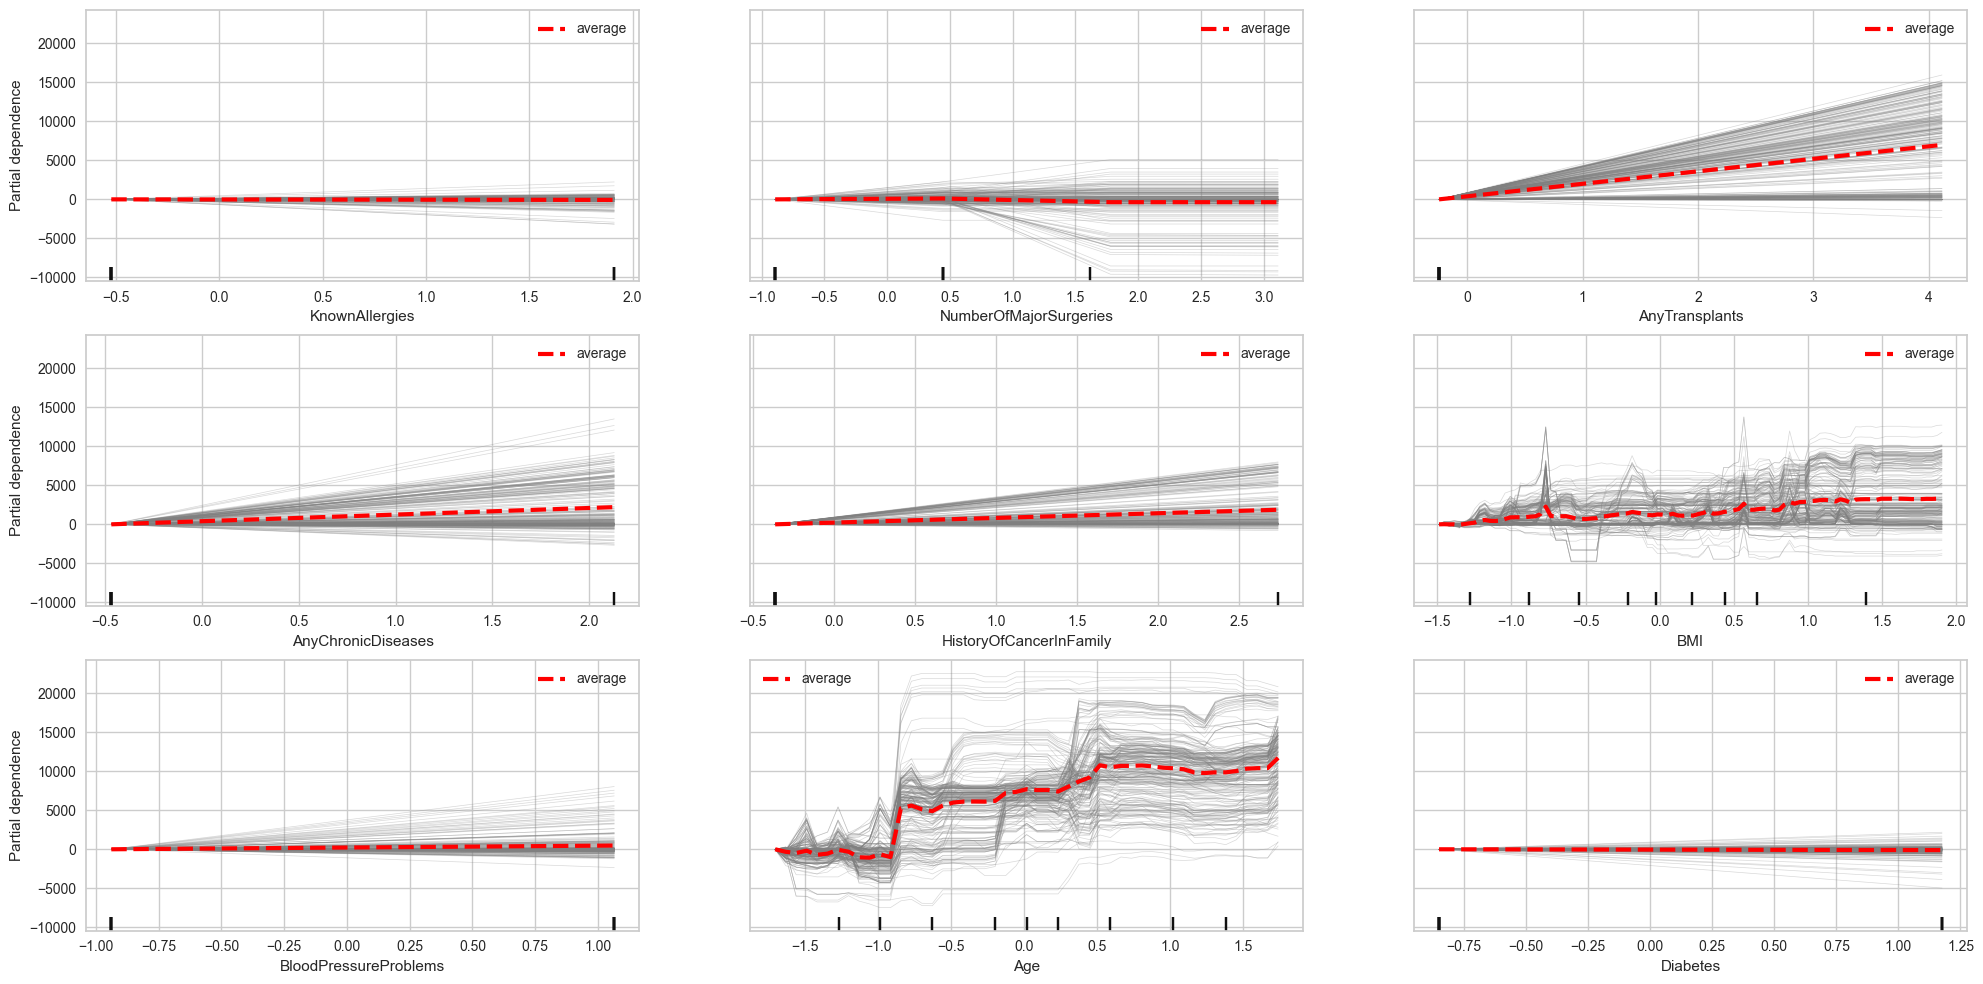

In [66]:
cols = xtest.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(rfmodel0.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=rfmodel0,
                                            ax=ax,
                                            X=xtest,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'}
                                           )

# Gradient Boosting

In [68]:
start_time = time.time()
gbmodel0=GradientBoostingRegressor()
gbmodel0.fit(xtrain,ytrain)
ypredtrain3=gbmodel0.predict(xtrain)
ypredtest3=gbmodel0.predict(xtest)
print(f'train Acc: {r2_score(ytrain,ypredtrain3)}')
print(f'test Acc: {r2_score(ytest,ypredtest3)}')
print(f'cv_score: {cross_val_score(gbmodel0,xsc,y,cv=5,).mean()}\n')

estimator=GradientBoostingRegressor()
param_grid={'n_estimators':[10,15,19,20,21,50,100,150],'learning_rate':[0.1,0.19,0.2,0.21,0.8,1]}
grid2=GridSearchCV(estimator,param_grid,scoring="r2",cv=5)
grid2.fit(xtrain,ytrain)
print(grid2.best_params_)

gbmodel=grid2
gbmodel.fit(xtrain,ytrain)
ypredtrain3=gbmodel.predict(xtrain)
ypredtest3=gbmodel.predict(xtest)
acc_GBM_Train = (r2_score(ytrain,ypredtrain3))
print('train Acc:', acc_GBM_Train)
acc_GBM_Test = (r2_score(ytest,ypredtest3))
print('test Acc:', acc_GBM_Test)
acc_GBM_CV = cross_val_score(gbmodel,xsc,y,cv=5,).mean()
print('cv_score:', acc_GBM_CV)


# other metrics
MAE_GBM_Test= metrics.mean_absolute_error(ytest,ypredtest3)
print('MAE:',MAE_GBM_Test)
MSE_GBM_Test = metrics.mean_squared_error(ytest,ypredtest3)
print('MSE:',MSE_GBM_Test)
RMSE_GBM_Test = np.sqrt(metrics.mean_squared_error(ytest,ypredtest3))
print('RMSE:', RMSE_GBM_Test)
MAPE_GBM_Test= (metrics.mean_absolute_percentage_error(ytest,ypredtest3))
print('MAPE:',MAPE_GBM_Test)


end_time = time.time()
GBM_elapsed_time = end_time - start_time
print(f"Elapsed Time: {GBM_elapsed_time} seconds")

train Acc: 0.8635682469956296
test Acc: 0.8444520425372849
cv_score: 0.7222154146929349

{'learning_rate': 0.19, 'n_estimators': 20}
train Acc: 0.7949199422986154
test Acc: 0.8450395028347657
cv_score: 0.7265532914525775
MAE: 1741.1987776705644
MSE: 5703269.67665052
RMSE: 2388.151937513717
MAPE: 0.07305477817880446
Elapsed Time: 2649.8312344551086 seconds


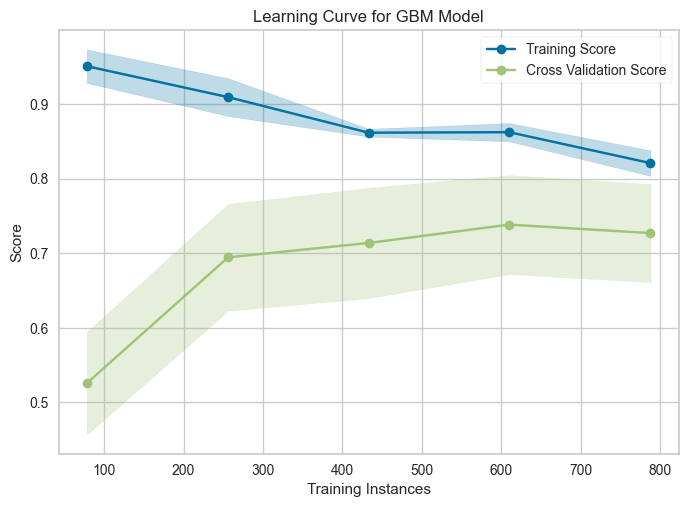

<Axes: title={'center': 'Learning Curve for GBM Model'}, xlabel='Training Instances', ylabel='Score'>

In [69]:
# Learning Curve
visualizer = learning_curve(gbmodel,xsc,y,cv=5, scoring='r2', title="Learning Curve for GB Model")
visualizer.show()

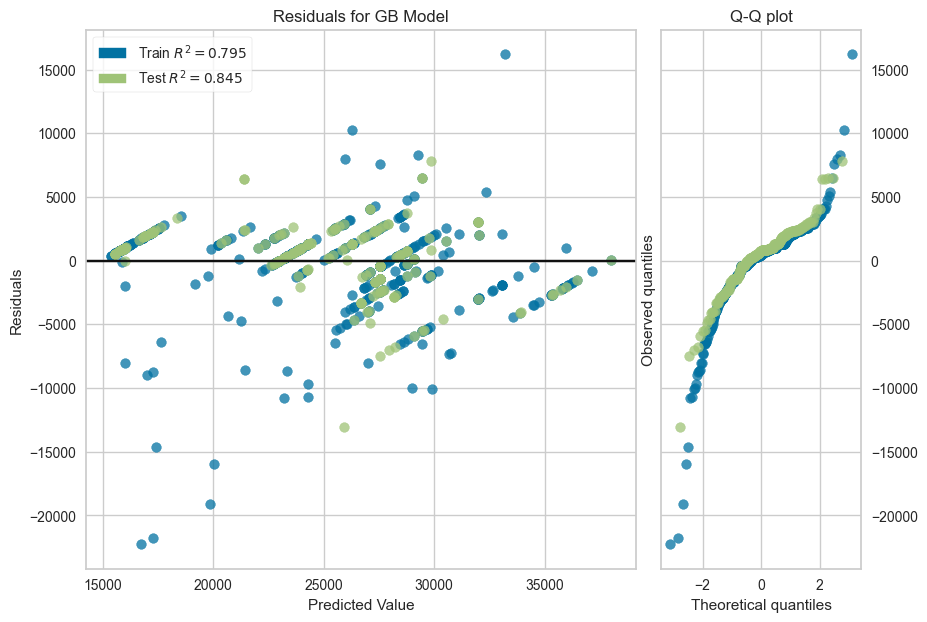

In [70]:
# Residuals plot + Q-Q plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = residuals_plot(estimator=gbmodel,
                   is_fitted=True,
                   ax=ax,
                   X_train=xtrain,
                   y_train=ytrain,
                   X_test=xtest,
                   y_test=ytest,
                   hist=False,
                   qqplot=True,
                  title="Residuals for GB Model"
                  )

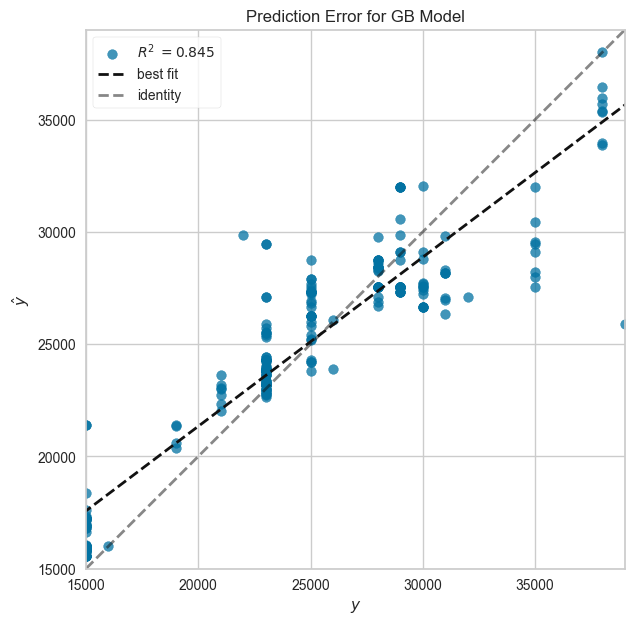

In [71]:
# Prediction error plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = prediction_error(estimator=gbmodel,
                     is_fitted=True,
                     ax=ax,
                     X_train=xtrain,
                     y_train=ytrain,
                     X_test=xtest,
                     y_test=ytest,
                     title="Prediction Error for GB Model")

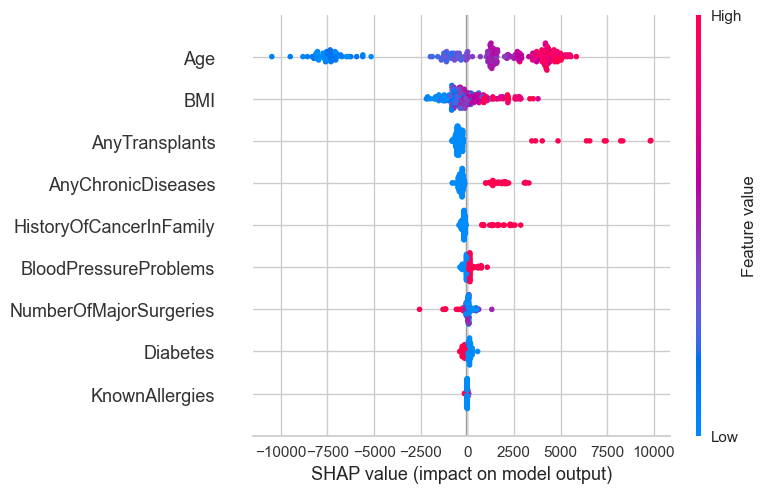

In [72]:
# SHAP Analysis
explainer2 = shap.TreeExplainer(gbmodel0)
GBM_shap_values = explainer2.shap_values(xtest)
shap.summary_plot(GBM_shap_values, xtest)

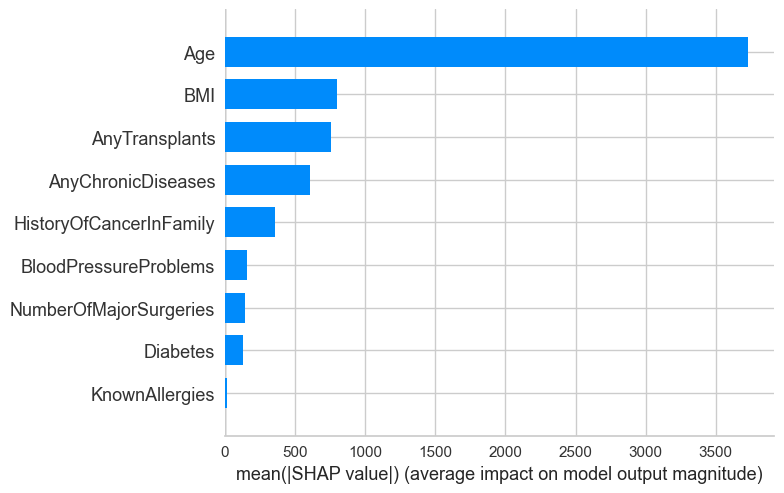

In [73]:
shap.summary_plot(GBM_shap_values, xtest, plot_type="bar")

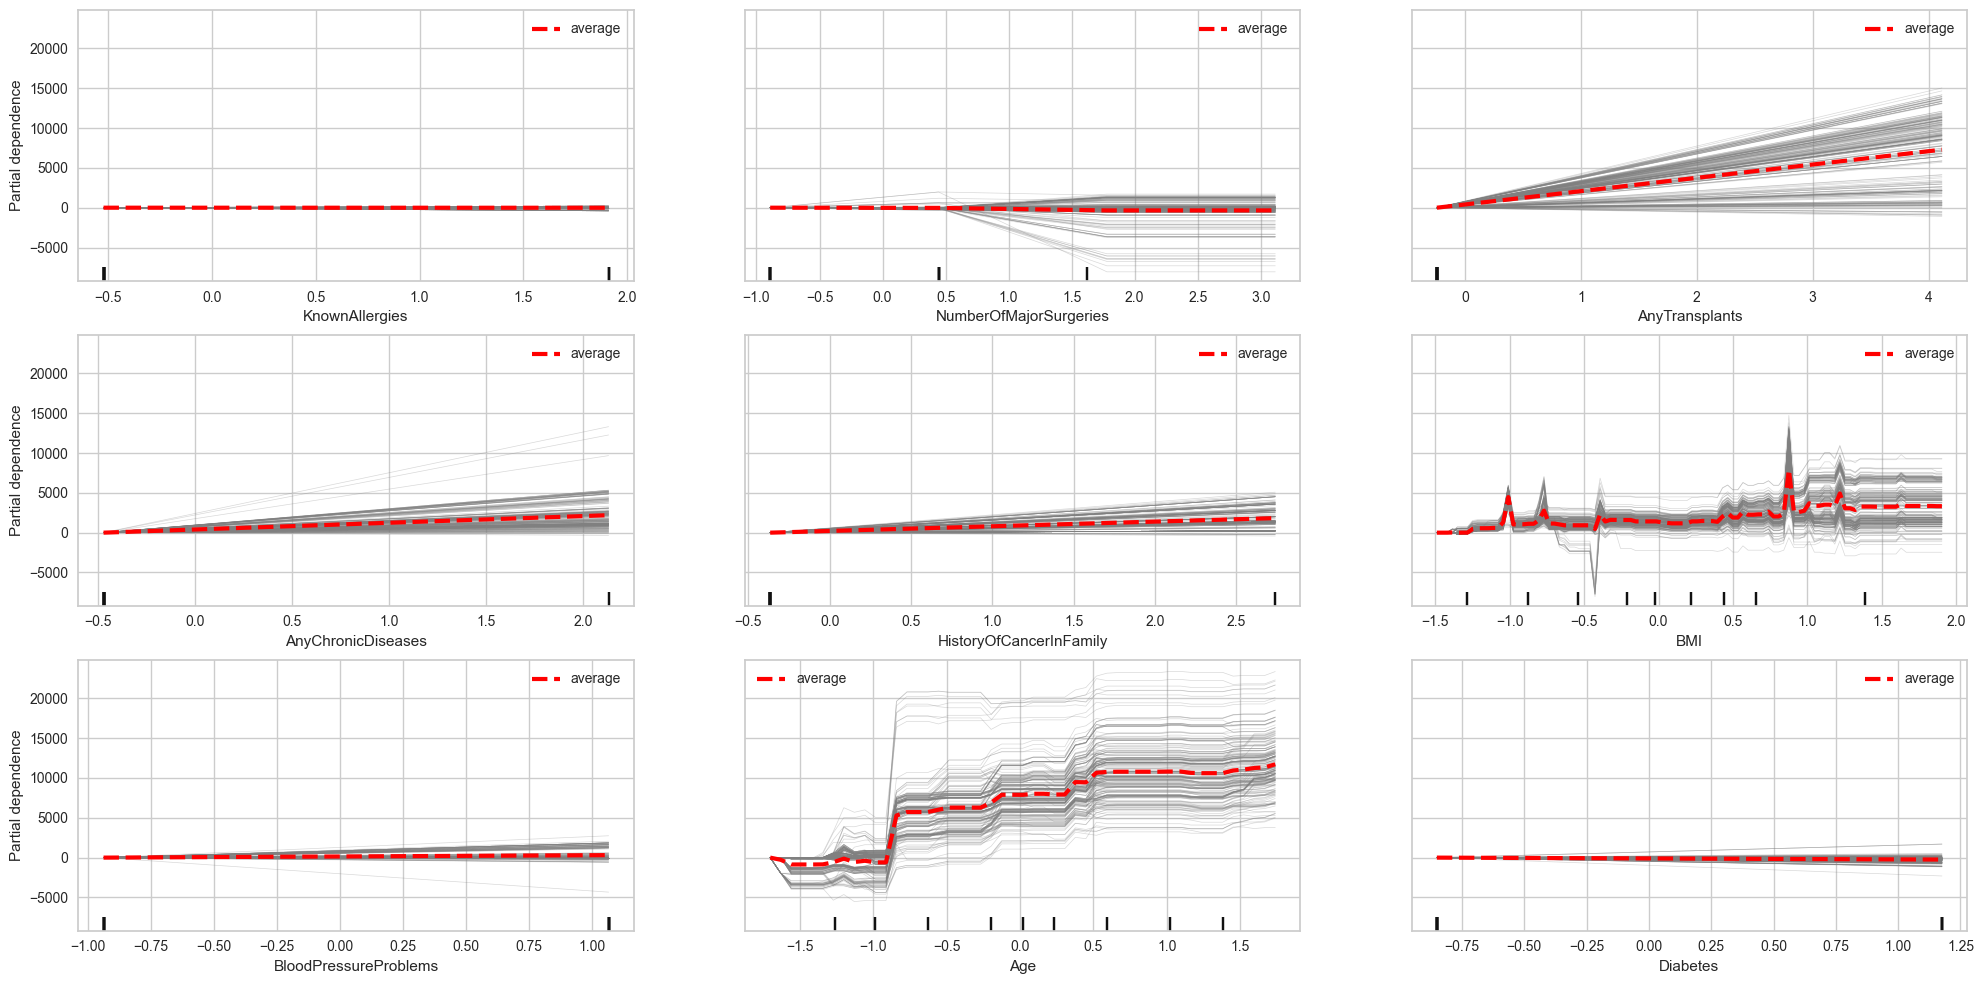

In [74]:
# ICE plot
cols = xtest.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(gbmodel0.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=gbmodel0,
                                            ax=ax,
                                            X=xtest,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            centered= True,
                                            n_cols=3,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

# XGBoost

In [75]:
start_time = time.time()
xgmodel0=XGBRegressor()
xgmodel0.fit(xtrain,ytrain)
ypredtrain4=xgmodel0.predict(xtrain)
ypredtest4=xgmodel0.predict(xtest)
print(f'train Acc: {r2_score(ytrain,ypredtrain4)}')
print(f'test Acc: {r2_score(ytest,ypredtest4)}')
print(f'cv_score: {cross_val_score(xgmodel0,xsc,y,cv=5,).mean()}\n')

estimator=XGBRegressor()
param_grid={'n_estimators':[50,100,150,200],'max_depth':[5,7,10],'gamma':[0,0.15,0.3,0.5,1], 
            'learning_rate': [0.1, 0.01, 0.05], 'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
grid3=GridSearchCV(estimator,param_grid,scoring="r2",cv=5)
grid3.fit(xtrain,ytrain)
print(grid3.best_params_)

xgmodel=grid3
xgmodel.fit(xtrain,ytrain)
ypredtrain4=xgmodel.predict(xtrain)
ypredtest4=xgmodel.predict(xtest)
acc_xgb_Train = (r2_score(ytrain,ypredtrain4))
print('train Acc:', acc_xgb_Train)
acc_xgb_Test = (r2_score(ytest,ypredtest4))
print('test Acc:', acc_xgb_Test)
acc_xgb_CV = (cross_val_score(xgmodel,xsc,y,cv=5,).mean())
print('cv_score:', acc_xgb_CV)

# other metrics
MAE_xgb_Test= metrics.mean_absolute_error(ytest,ypredtest4)
print('MAE:',MAE_xgb_Test)
MSE_xgb_Test = metrics.mean_squared_error(ytest,ypredtest4)
print('MSE:',MSE_xgb_Test)
RMSE_xgb_Test = np.sqrt(metrics.mean_squared_error(ytest,ypredtest4))
print('RMSE:', RMSE_xgb_Test)
MAPE_xgb_Test= (metrics.mean_absolute_percentage_error(ytest,ypredtest4))
print('MAPE:',MAPE_xgb_Test)

end_time = time.time()
xgb_elapsed_time = end_time - start_time
print(f"Elapsed Time: {xgb_elapsed_time} seconds")

train Acc: 0.998734912770186
test Acc: 0.7961698441107473
cv_score: 0.6907889064648618

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
train Acc: 0.8997943696581782
test Acc: 0.8453861755867764
cv_score: 0.7481175597526597
MAE: 1572.7188527960527
MSE: 5690510.501051366
RMSE: 2385.479092562198
MAPE: 0.06650146093046884
Elapsed Time: 8882.548669815063 seconds


## Professor, I have put the below code to markdown as the system is getting crashed while running. The above cell took 2 hour 45 minutes(8882.54 seconds) [to run for hyper paramter tuning({'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6})] to get output.

# Learning Curve
visualizer = learning_curve(xgmodel,xsc,y,cv=5, scoring='r2', title="Learning Curve for XGB Model")
visualizer.show()

# Residuals plot + Q-Q plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = residuals_plot(estimator=xgmodel,
                   is_fitted=True,
                   ax=ax,
                   X_train=xtrain,
                   y_train=ytrain,
                   X_test=xtest,
                   y_test=ytest,
                   hist=False,
                   qqplot=True,
                  title="Residuals for XGB Model"
                  )

# Prediction error plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = prediction_error(estimator=xgmodel,
                     is_fitted=True,
                     ax=ax,
                     X_train=xtrain,
                     y_train=ytrain,
                     X_test=xtest,
                     y_test=ytest,
                     title="Prediction Error for XGB Model")

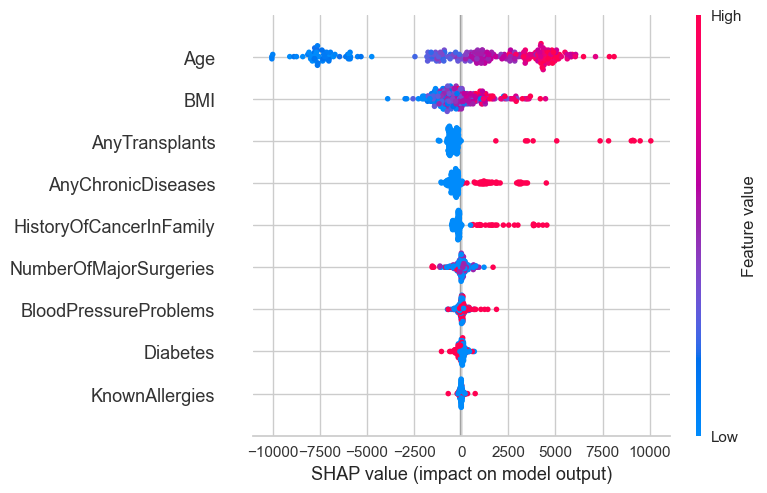

In [76]:
# SHAP Analysis
explainer3 = shap.TreeExplainer(xgmodel0)
XGB_shap_values = explainer3.shap_values(xtest)
shap.summary_plot(XGB_shap_values, xtest)

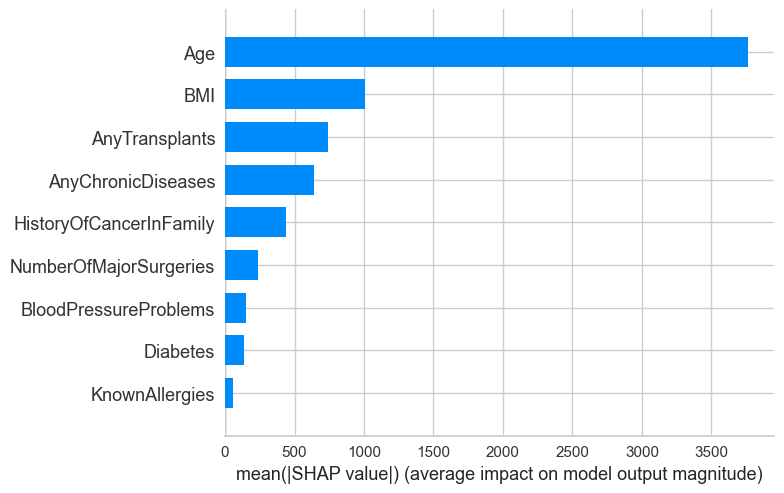

In [77]:
shap.summary_plot(XGB_shap_values, xtest, plot_type="bar")

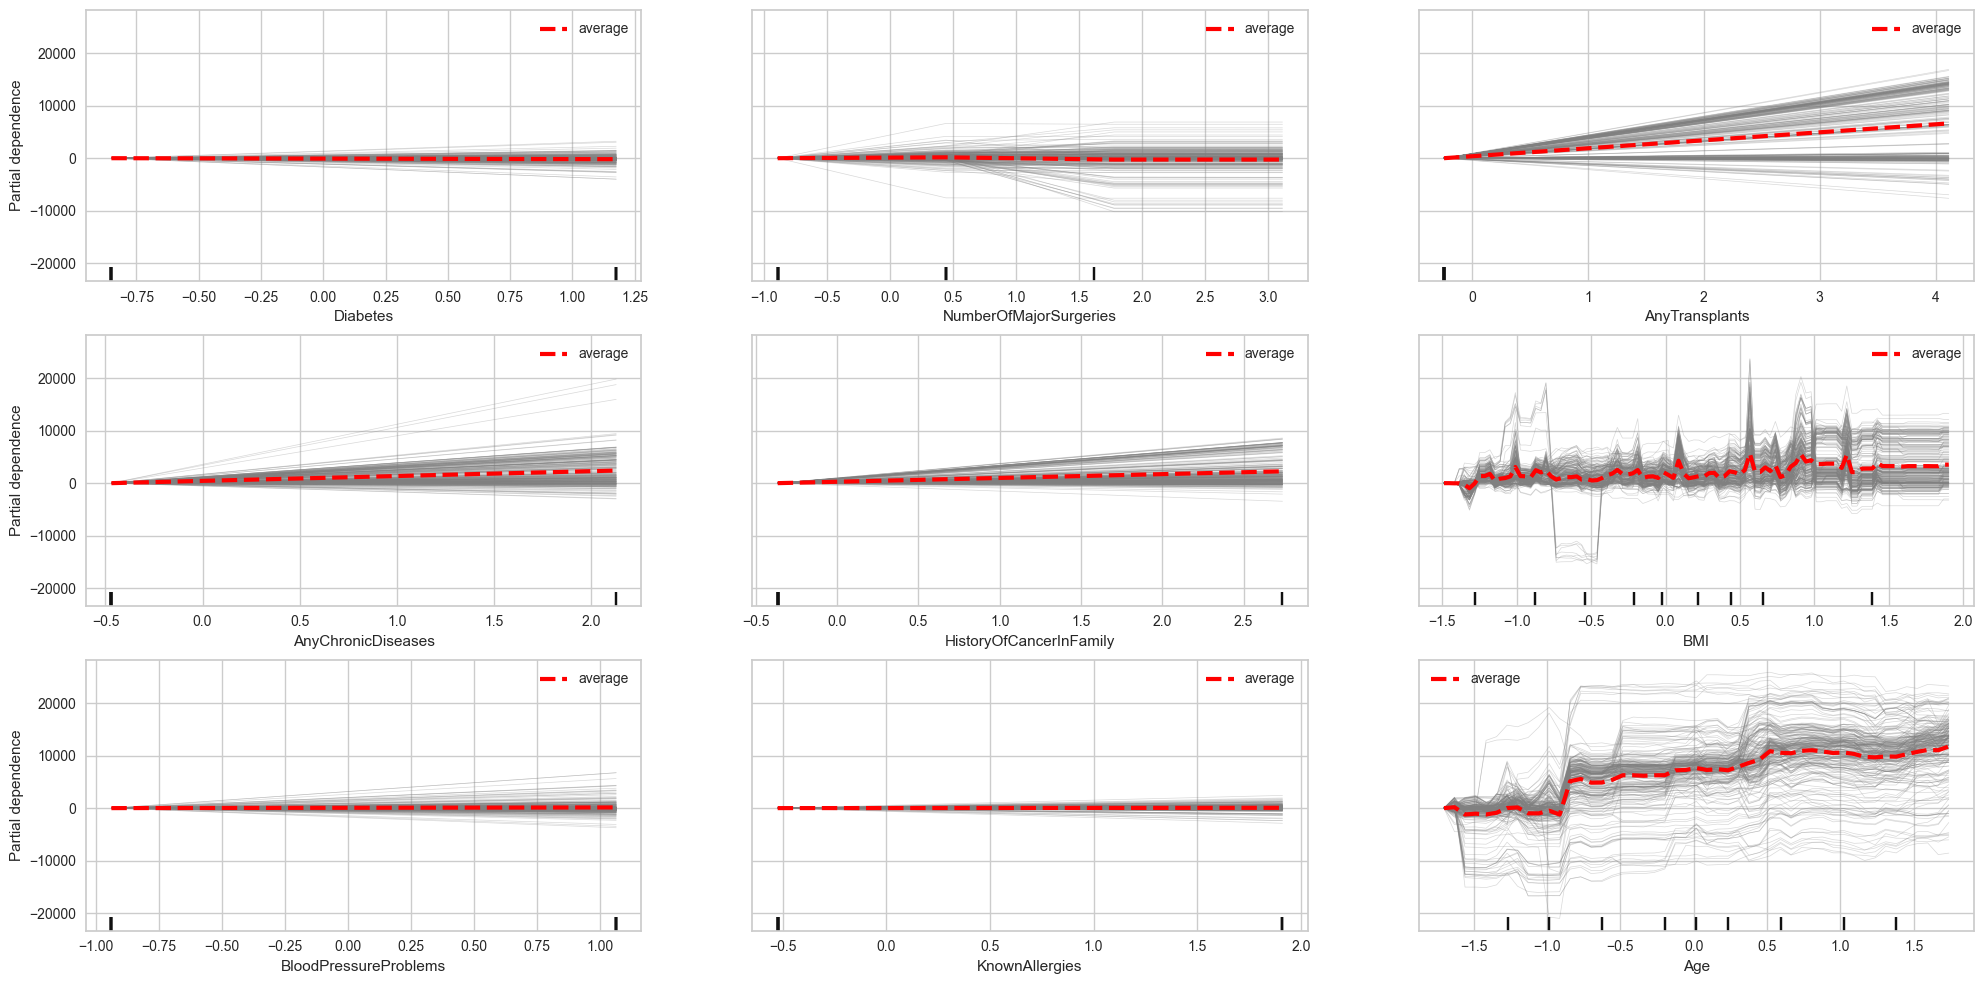

In [80]:
# ICE plot
cols = xtest.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(xgmodel0.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=xgmodel0,
                                            ax=ax,
                                            X=xtest,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            centered= True,
                                            n_cols=3,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

# Final Result

In [78]:
models = pd.DataFrame({
    'Model': ['RF Model', 'GB Model', 'XGB Model'],
    'Train Score (R2)': [acc_RF_Train*100, acc_GBM_Train*100, acc_xgb_Train*100],
    'Test Score (R2)': [acc_RF_Test*100, acc_GBM_Test*100, acc_xgb_Test*100],
    'CV Score (R2)': [acc_RF_CV*100, acc_GBM_CV*100, acc_xgb_CV*100],
    'MAE Score': [MAE_RF_Test, MAE_GBM_Test, MAE_xgb_Test],
    'RMSE Score': [RMSE_RF_Test, RMSE_GBM_Test, RMSE_xgb_Test],
    'MAPE Score (%)': [MAPE_RF_Test*100, MAPE_GBM_Test*100, MAPE_xgb_Test*100],
    'Elapsed Time (Sec)': [RF_elapsed_time, GBM_elapsed_time, xgb_elapsed_time],
    })
models.sort_values(by='Test Score (R2)', ascending=False)

Model  Train Score (R2)  Test Score (R2)  CV Score (R2)    MAE Score  \
2  XGB Model         89.979437        84.538618      74.811756  1572.718853   
0   RF Model         95.775950        84.519817      73.424693  1366.119753   
1   GB Model         79.491994        84.503950      72.655329  1741.198778   

    RMSE Score  MAPE Score (%)  Elapsed Time (Sec)  
2  2385.479093        6.650146         8882.548670  
0  2386.928987        5.768792          290.670042  
1  2388.151938        7.305478         2649.831234

XGBoost model outperformed the other models. However, it was computationally expensive as it took considerable computational resources to run.